In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from pingouin import partial_corr

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader

from collections import Counter
import math

Matplotlib created a temporary cache directory at /scratch_local/esx208-1179520/tmp/matplotlib-1arixo8y because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"
doc_metrics_file = '/mnt/qb/work/eickhoff/esx208/MechIR/data/TFC1-data_w_metrics.tsv'
query_metrics_file = '/mnt/qb/work/eickhoff/esx208/MechIR/data/TREC-queries-data_w_metrics.tsv'

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('patch_head', 'original_scores'))
perturbed_scores = np.load(data_path.replace('patch_head', 'perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda x: x.rsplit(' ', 1)[1])
doc_metrics_data = pd.read_csv(doc_metrics_file, sep='\t').drop_duplicates(subset=['docno'])
query_metrics_data = pd.read_csv(query_metrics_file, sep='\t').drop_duplicates(subset=['query_id'])
all_data_pd = all_data_pd.merge(doc_metrics_data, on=['docno'], suffixes=('', '_doc'))
all_data_pd = all_data_pd.merge(query_metrics_data, left_on=['qid'], right_on=['query_id'], suffixes=('', '_query'))

/scratch_local/esx208-1179520/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
searcher = LuceneSearcher.from_prebuilt_index('msmarco-v1-passage-slim')
reader = IndexReader.from_prebuilt_index('msmarco-v1-passage-slim')

Feb 26, 2025 1:20:18 PM org.apache.lucene.store.MMapDirectory lookupProvider


In [4]:
def get_tfidf(text, reader):
    terms = text.split()
    tf = Counter(terms)
    num_docs = reader.stats()['documents']
    
    tfidf_scores = dict()
    for term, term_count in tf.items():
        try:
            df = reader.get_term_counts(term)[0]
        except:
            df = 0
        if df > 0:
            tf = term_count / len(terms)
            idf = math.log(num_docs / df)
            tfidf_scores[term] = tf * idf
        else:
            tfidf_scores[term] = 0
    return tfidf_scores

def get_tf_injected_term(text, term):
    terms = text.split()
    tf = Counter(terms)
    if term in tf:
        return tf[term]
    else:
        return 0

def get_tfidf_injected_term(text, term, reader):
    tfidf_scores = get_tfidf(text, reader)
    if term in tfidf_scores:
        return tfidf_scores[term]
    else:
        return 0
    
def gini_index(matrix):
    array = matrix.flatten()
    array = np.abs(array)
    array = np.sort(array)

    n = len(array)
    index = np.arange(1, n+1)
    cumulative_sum = np.sum(np.abs(array[:, None] - array))
    gini = cumulative_sum / (2 * n**2 * np.mean(array))

    return gini


In [5]:
patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
patching_effect_normalised_clip = np.clip(patching_results_normalised, -1, 1)

all_data_pd['idf_injected_term'] = all_data_pd['injected_term'].apply(lambda x: get_tfidf(x, reader)[x])
all_data_pd['tf_injected_term'] = all_data_pd.apply(lambda x: get_tf_injected_term(x['text_tokenized'], x['injected_term']), axis=1)
all_data_pd['tfidf_injected_term'] = all_data_pd.apply(lambda x: get_tfidf_injected_term(x['text_tokenized'], x['injected_term'], reader), axis=1)
all_data_pd['injected_term_token_len'] = all_data_pd['injected_term'].apply(lambda x: len(tokenizer(x, add_special_tokens=False)['input_ids']))

In [6]:
def add_target_metrics(data, patching_results, original_scores, perturbed_scores):
    data['original_score'] = original_scores
    data['perturbed_score'] = perturbed_scores

    score_difference = perturbed_scores - original_scores
    data['score_delta'] = score_difference
    
    patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))
    patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
    patching_effect_normalised_clip = np.clip(patching_results_normalised, -1, 1)
    
    data['patching_effect_std'] = np.std(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-1,-2))
    data['patching_effect_absolute_mean'] = np.mean(np.abs(patching_results - original_scores[:, np.newaxis, np.newaxis]), axis=(-1,-2))
    data['patching_effect_normalised_std'] = np.std(patching_results_normalised, axis=(-1,-2))
    data['patching_effect_normalised_absolute_mean'] = np.mean(np.abs(patching_results_normalised), axis=(-1,-2))
    data['patching_effect_normalised_square_std'] = np.std(patching_results_normalised_square, axis=(-1,-2))
    data['patching_effect_normalised_square_absolute_mean'] = np.mean(np.abs(patching_results_normalised_square), axis=(-1,-2))
    data['patching_effect_normalised_clip_std'] = np.std(patching_effect_normalised_clip, axis=(-1,-2))
    data['patching_effect_normalised_clip_absolute_mean'] = np.mean(np.abs(patching_effect_normalised_clip), axis=(-1,-2))
    data['gini'] = [gini_index(np.abs(matrix)) for matrix in (patching_results - original_scores[:, np.newaxis, np.newaxis])]
    data['gini_normalised'] = [gini_index(np.abs(matrix)) for matrix in patching_results_normalised]
    data['gini_normalised_square'] = [gini_index(np.abs(matrix)) for matrix in patching_results_normalised_square]
    
    return data

In [7]:
add_target_metrics(all_data_pd, patching_results, original_scores, perturbed_scores);

In [9]:
all_data_pd.to_csv(data_path.replace('_patch_head.npy', '_features.tsv'), sep='\t', index=False)

In [102]:
all_data_pd_scores_cut = all_data_pd[(all_data_pd['score_delta'] > 2.5) & (all_data_pd['score_delta'] < 12)]

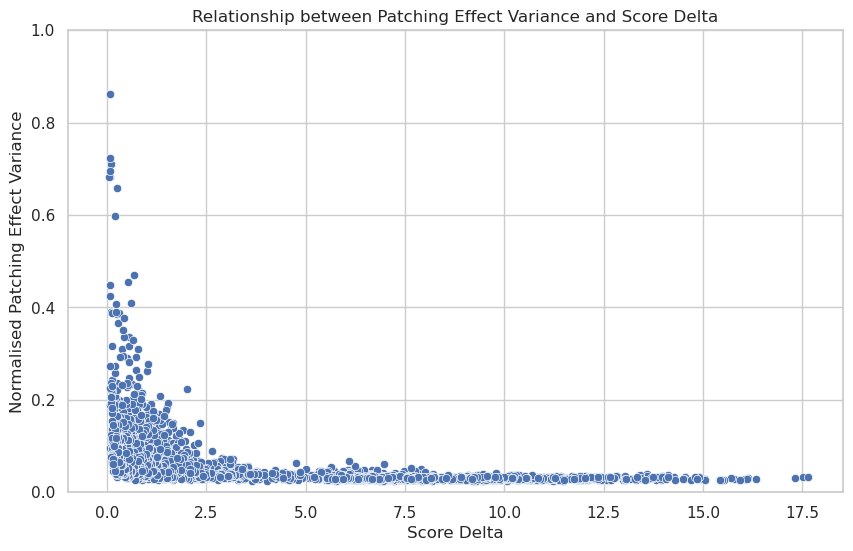

In [103]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_std', x='score_delta')
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.ylim(0,1)
plt.show()

<Axes: xlabel='score_delta', ylabel='gini'>

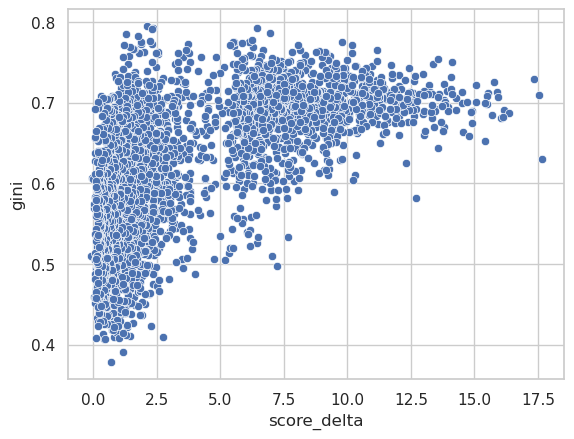

In [104]:
sns.scatterplot(data=all_data_pd, y='gini', x='score_delta')

<Axes: xlabel='score_delta', ylabel='gini_normalised'>

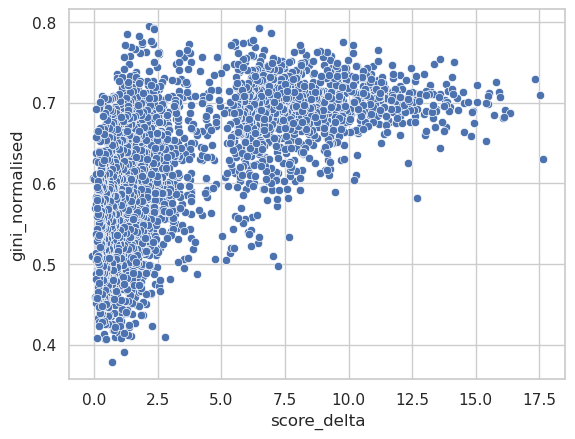

In [105]:
sns.scatterplot(data=all_data_pd, y='gini_normalised', x='score_delta')

<Axes: xlabel='score_delta', ylabel='gini_normalised_square'>

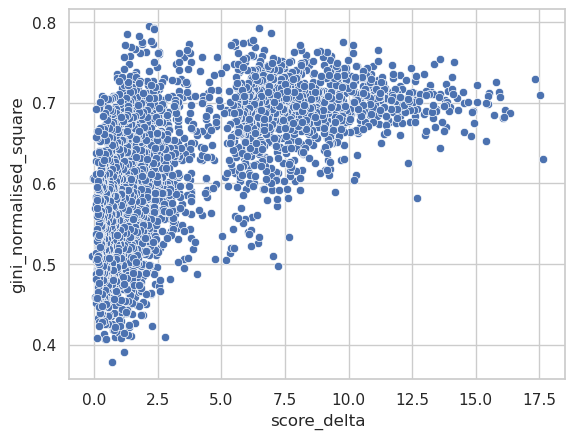

In [106]:
sns.scatterplot(data=all_data_pd, y='gini_normalised_square', x='score_delta')

In [107]:
all_data_pd.sort_values(by='gini', ascending=False).head(10)

qid                                        query    docno  \
1375  1112341        what is the daily life of thai people  4595999   
762     87452                   causes of military suicide  8441957   
3090  1112341        what is the daily life of thai people  3670747   
3093  1112341        what is the daily life of thai people  4102529   
690    997622           where is the show shameless filmed  3685526   
2393  1112341        what is the daily life of thai people  1707317   
3145  1112341        what is the daily life of thai people  1267515   
1092    67316  can fever cause miscarriage early pregnancy  5836325   
3100  1112341        what is the daily life of thai people  2936513   
3133  1112341        what is the daily life of thai people  1035064   

                                                   text  relevance  perturbed  \
1375  Muay Thai Gear Guide: Boxing Gloves vs. Muay T...          1       True   
762   Ask to see nutrition information for the foods...          0       True   
3090  Thai money is called the baht, and the exchang...          3       True   
3093  4 Muay Thai. The anceient art of the eight wea...          3       True   
690   310 S Michigan Ave This is a property located ...          0       True   
2393  1 The Baht banknotes shown above are still a v...          2       True   
3145  The flag of the Kingdom of Thailand (Thai: ธงไ...          3       True   
1092  ob-gyn. Yes, as long as the water temperature ...          1       True   
3100  1 RMB (Chinese Yuan Renminbi - CNY) is approxi...          3       True   
3133  Flag of Thailand. Thailand (Kingdom of Thailan...          3       True   

      perturbed_score  rank  original_score  score_delta  ...  \
1375        87.090057   388       84.953842     2.136215  ...   
762         84.816368   251       78.350517     6.465851  ...   
3090        91.733757   171       89.368462     2.365295  ...   
3093        90.690010   219       88.353653     2.336357  ...   
690         89.854378   363       82.885895     6.968483  ...   
2393        89.201561   312       87.908516     1.293045  ...   
3145        90.788239   209       89.012123     1.776115  ...   
1092        86.663269   422       80.424927     6.238342  ...   
3100        91.690369   173       89.439384     2.250984  ...   
3133        89.489632   289       87.617813     1.871819  ...   

     patching_effect_absolute_mean patching_effect_normalised_std  \
1375                      0.049020                       0.056673   
762                       0.135681                       0.048583   
3090                      0.058878                       0.065068   
3093                      0.053291                       0.053346   
690                       0.174321                       0.061871   
2393                      0.033438                       0.073214   
3145                      0.044279                       0.063622   
1092                      0.154105                       0.055993   
3100                      0.055227                       0.059959   
3133                      0.046724                       0.062201   

     patching_effect_normalised_absolute_mean  \
1375                                 0.022947   
762                                  0.020984   
3090                                 0.024892   
3093                                 0.022810   
690                                  0.025016   
2393                                 0.025860   
3145                                 0.024930   
1092                                 0.024703   
3100                                 0.024535   
3133                                 0.024962   

     patching_effect_normalised_square_std  \
1375                              0.051327   
762                               0.048012   
3090                              0.059932   
3093                              0.049043   
690                               0.061243   
2393                              0.057915  

<Axes: >

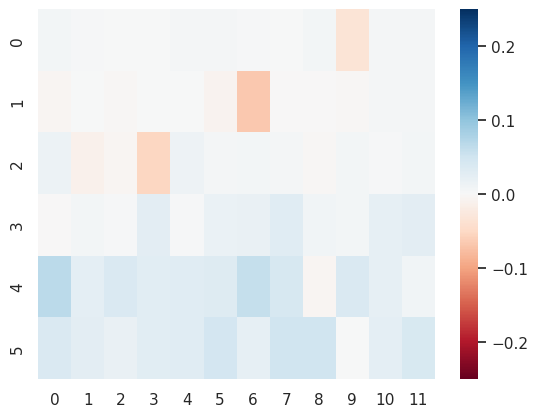

In [108]:
sns.heatmap(
    np.mean(patching_results_normalised_square, axis=0), 
    cmap='RdBu', 
    vmin=-0.25, 
    vmax=0.25
)

In [72]:
all_data_pd['gini']

0       0.709444
1       0.730078
2       0.690587
3       0.630607
4       0.712927
          ...   
3995    0.537092
3996    0.533780
3997    0.536046
3998    0.506416
3999    0.612400
Name: gini, Length: 4000, dtype: float64

In [74]:
all_data_pd['gini_normalised']

0       0.709444
1       0.730078
2       0.690587
3       0.630606
4       0.712927
          ...   
3995    0.537092
3996    0.533780
3997    0.536046
3998    0.506416
3999    0.612400
Name: gini_normalised, Length: 4000, dtype: float64

In [109]:
all_data_pd.sort_values(by='gini', ascending=False)

qid                                         query    docno  \
1375  1112341         what is the daily life of thai people  4595999   
762     87452                    causes of military suicide  8441957   
3090  1112341         what is the daily life of thai people  3670747   
3093  1112341         what is the daily life of thai people  4102529   
690    997622            where is the show shameless filmed  3685526   
...       ...                                           ...      ...   
2856   555530      what are best foods to lower cholesterol  4080244   
3655   324585  how much money do motivational speakers make  1536990   
3854   914916           what type of tissue are bronchioles  5730355   
3309   168216   does legionella pneumophila cause pneumonia   731200   
3539  1122767                 what amino produces carnitine  4784605   

                                                   text  relevance  perturbed  \
1375  Muay Thai Gear Guide: Boxing Gloves vs. Muay T...          1       True   
762   Ask to see nutrition information for the foods...          0       True   
3090  Thai money is called the baht, and the exchang...          3       True   
3093  4 Muay Thai. The anceient art of the eight wea...          3       True   
690   310 S Michigan Ave This is a property located ...          0       True   
...                                                 ...        ...        ...   
2856  • Soluble fiber can bring down bad LDL cholest...          2       True   
3655  Related articles: Event Planner, Event Photogr...          3       True   
3854  The terminal bronchiole is the most distal seg...          3       True   
3309  Amyotrophic horizontal sclerosis (ALS), also c...          3       True   
3539  Nutrients for L-carnitine Production. Niacin, ...          3       True   

      perturbed_score  rank  original_score  score_delta  ...  \
1375        87.090057   388       84.953842     2.136215  ...   
762         84.816368   251       78.350517     6.465851  ...   
3090        91.733757   171       89.368462     2.365295  ...   
3093        90.690010   219       88.353653     2.336357  ...   
690         89.854378   363       82.885895     6.968483  ...   
...               ...   ...             ...          ...  ...   
2856       103.058670   219      102.016167     1.042503  ...   
3655       103.603088    22      103.186134     0.416954  ...   
3854       101.763084    28      101.298538     0.464546  ...   
3309       103.904572   200      102.717239     1.187332  ...   
3539       106.127899    11      105.420593     0.707306  ...   

     patching_effect_absolute_mean patching_effect_normalised_std  \
1375                      0.049020                       0.056673   
762                       0.135681                       0.048583   
3090                      0.058878                       0.065068   
3093                      0.053291                       0.053346   
690                       0.174321                       0.061871   
...                            ...                            ...   
2856                      0.037797                       0.040314   
3655                      0.020326                       0.054150   
3854                      0.018813                       0.050522   
3309                      0.046886                       0.046870   
3539                      0.021409                       0.027411   

     patching_effect_normalised_absolute_mean  \
1375                                 0.022947   
762                                  0.020984   
3090                                 0.024892   
3093                                 0.022810   
690                                  0.025016   
...                                       ...   
2856                                 0.036256   
3655                                 0.048748   
3854                                 0.040498   
3309                                 0.039488   
3539                   

<Axes: >

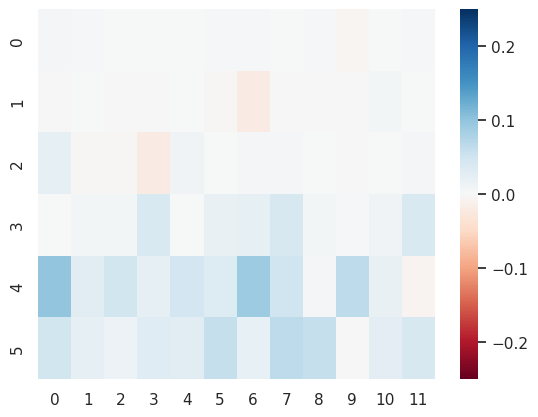

In [117]:
sns.heatmap(
    np.mean(patching_results_normalised_square[all_data_pd.sort_values(by='gini', ascending=False).head(1000).index], axis=0), 
    cmap='RdBu', 
    vmin=-0.25, 
    vmax=0.25
)

<Axes: >

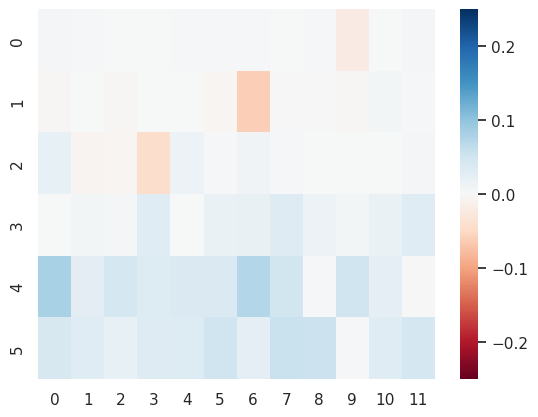

In [142]:
sns.heatmap(
    np.mean(patching_results_normalised_square[all_data_pd[all_data_pd['gini'] > 0.6].index], axis=0), 
    cmap='RdBu', 
    vmin=-0.25, 
    vmax=0.25
)

<Axes: >

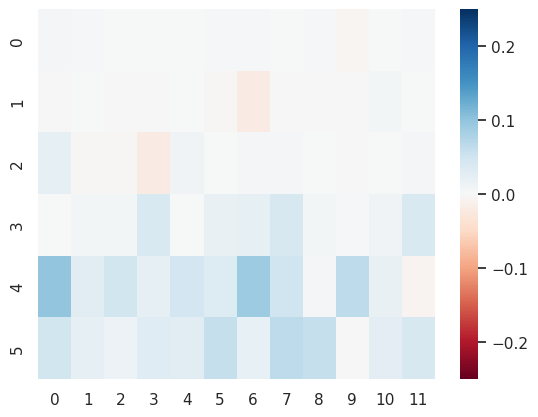

In [62]:
sns.heatmap(
    np.mean(patching_results_normalised_square[all_data_pd.sort_values(by='gini', ascending=False).head(500).index], axis=0), 
    cmap='RdBu', 
    vmin=-0.25, 
    vmax=0.25
)

<Axes: >

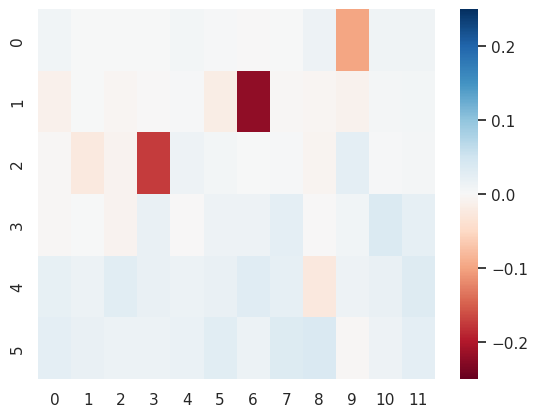

In [57]:
sns.heatmap(
    np.mean(patching_results_normalised_square[all_data_pd.sort_values(by='patching_effect_normalised_absolute_mean', ascending=False).head(1000).index], axis=0), 
    cmap='RdBu', 
    vmin=-0.25, 
    vmax=0.25
)

<Axes: >

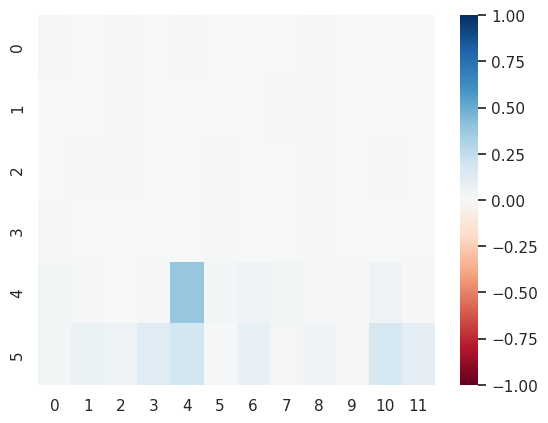

In [44]:
sns.heatmap(patching_results_normalised[all_data_pd.sort_values(by='gini', ascending=False).index[0]], cmap='RdBu', vmin=-1, vmax=1)

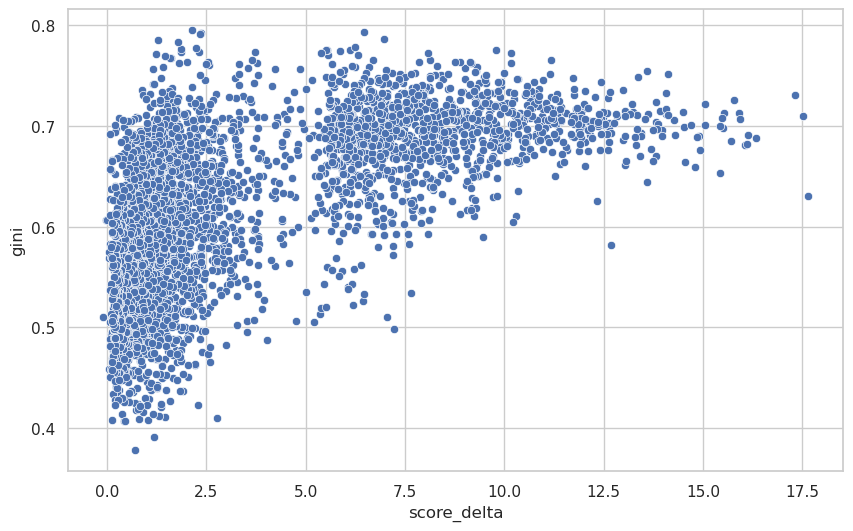

In [135]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='gini', x='score_delta')

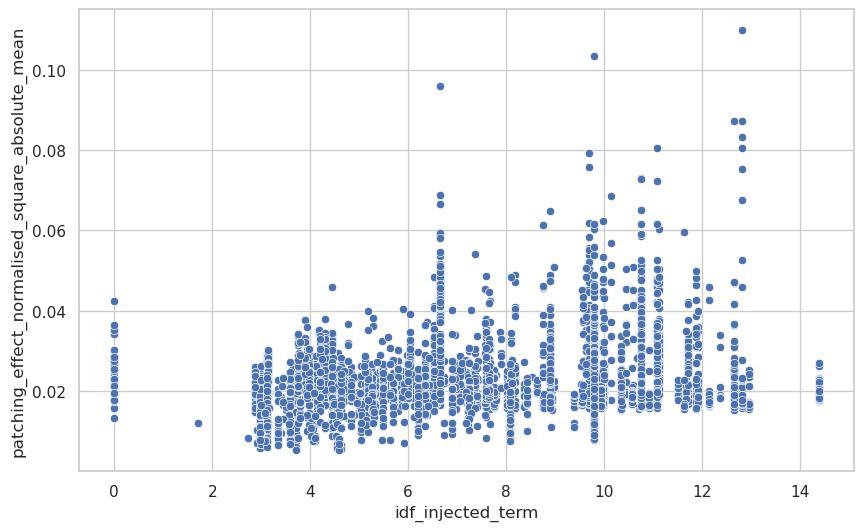

In [144]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_square_absolute_mean', x='idf_injected_term')

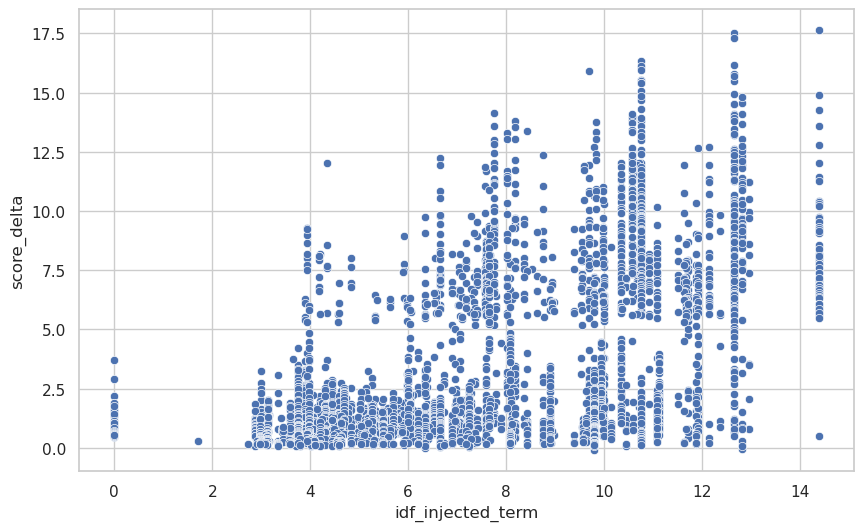

In [145]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='score_delta', x='idf_injected_term')

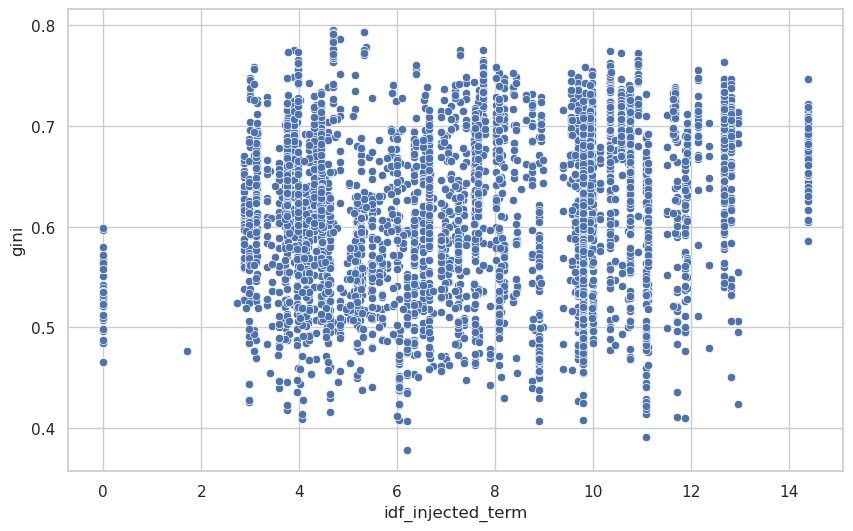

In [136]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='gini', x='idf_injected_term')

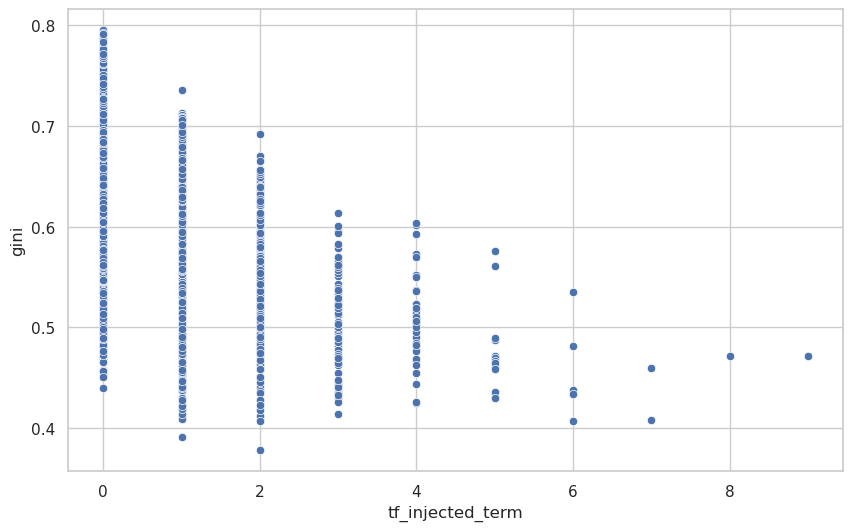

In [137]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='gini', x='tf_injected_term')

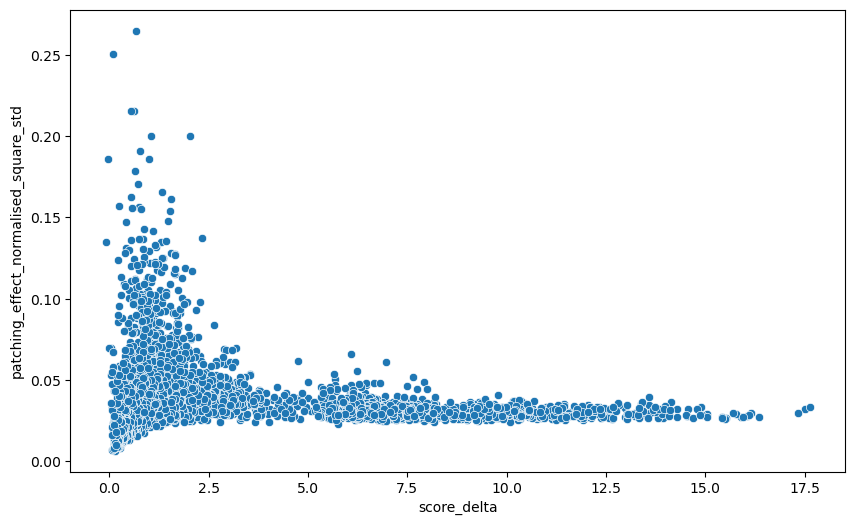

In [19]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_square_std', x='score_delta')

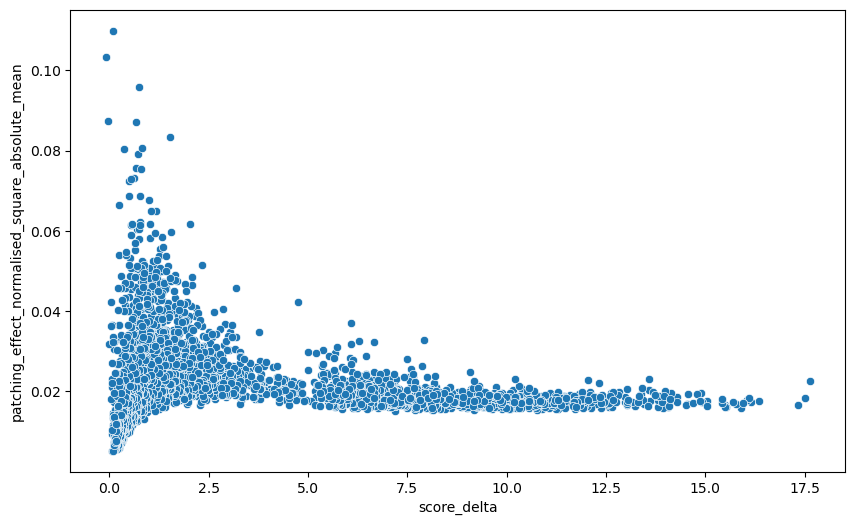

In [20]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_square_absolute_mean', x='score_delta')

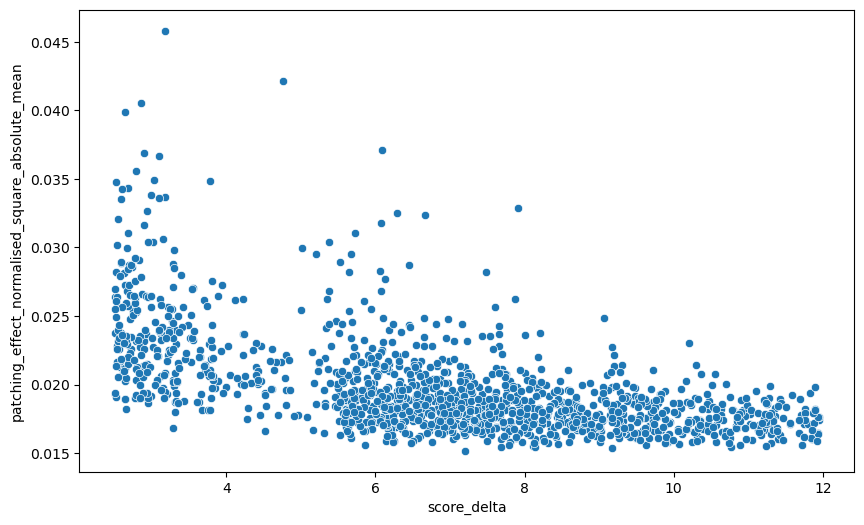

In [21]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd_scores_cut, y='patching_effect_normalised_square_absolute_mean', x='score_delta')

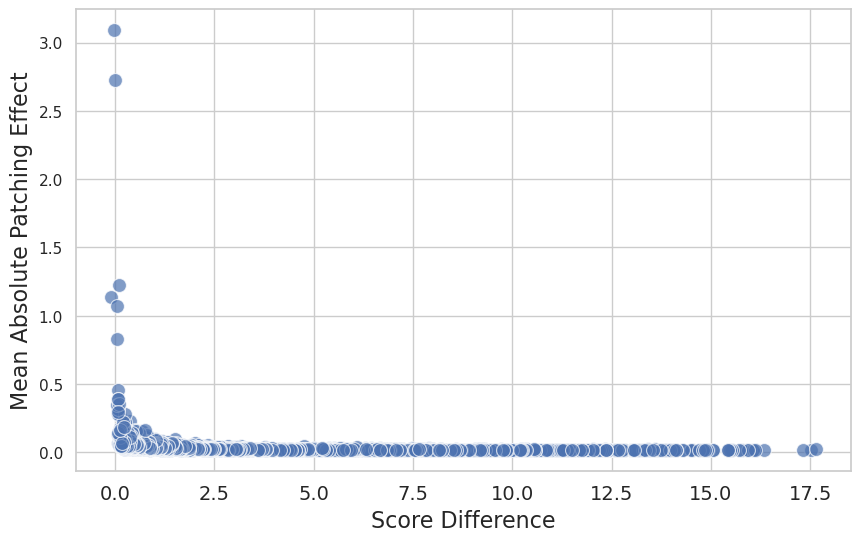

In [26]:
# Create improved scatter plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter plot with color palette and transparency
sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_absolute_mean', x='score_delta', s=100, alpha=0.7)

# Customize labels and title
plt.xlabel('Score Difference', fontsize=16)
plt.ylabel('Mean Absolute Patching Effect', fontsize=16)
# plt.title('Relationship between Mean Absolute Patching Effect and Score Difference', fontsize=20)
plt.xticks(fontsize=14)

# Add grid
plt.grid(True)

# Save the plot as an image file
plt.savefig('/mnt/qb/work/eickhoff/esx208/MechIR/notebooks/plots/dual_encoder_scatter_plot_no_penalty.pdf', bbox_inches='tight')
plt.show()

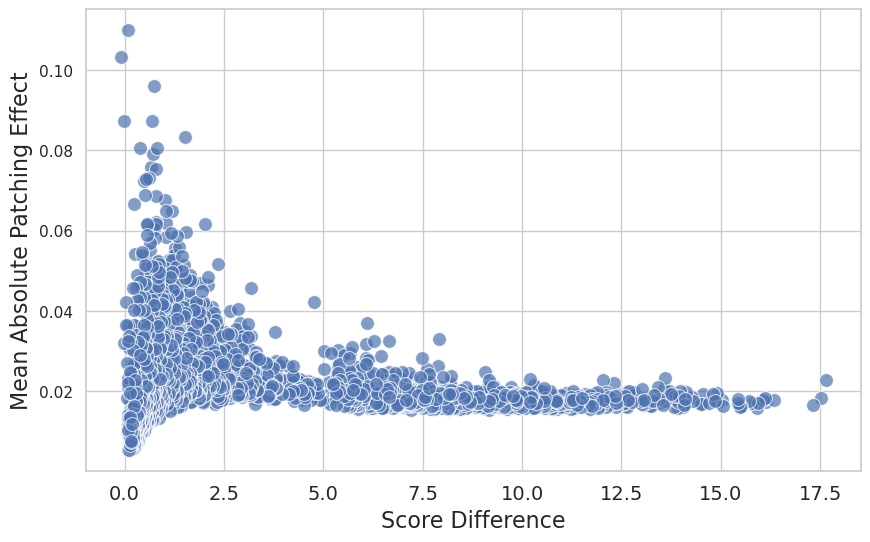

In [27]:
# Create improved scatter plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter plot with color palette and transparency
sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_square_absolute_mean', x='score_delta', s=100, alpha=0.7)

# Customize labels and title
plt.xlabel('Score Difference', fontsize=16)
plt.ylabel('Mean Absolute Patching Effect', fontsize=16)
# plt.title('Relationship between Mean Absolute Patching Effect and Score Difference', fontsize=16)
plt.xticks(fontsize=14)

# Add grid
plt.grid(True)

# Save the plot as an image file
plt.savefig('/mnt/qb/work/eickhoff/esx208/MechIR/notebooks/plots/dual_encoder_scatter_plot_with_penalty.pdf', bbox_inches='tight')
plt.show()

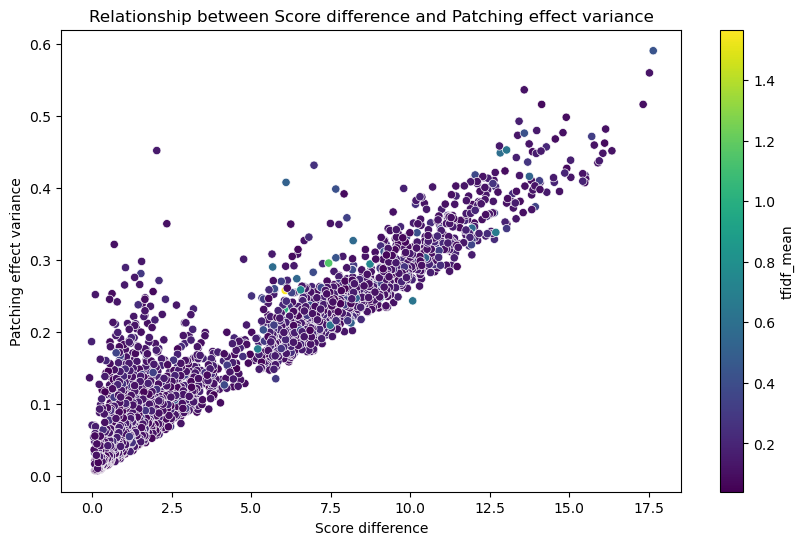

In [13]:
def plot_relationship_continous_colorbar(x, y, hue, data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(data=data, x=x, y=y, hue=hue, palette='viridis', legend=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    norm = plt.Normalize(data[hue].min(), data[hue].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    scatter_plot.figure.colorbar(sm, label=hue, orientation='vertical', ax=scatter_plot)
    plt.show()
    
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'tfidf_mean', all_data_pd, 'Relationship between Score difference and Patching effect variance', 'Score difference', 'Patching effect variance')    

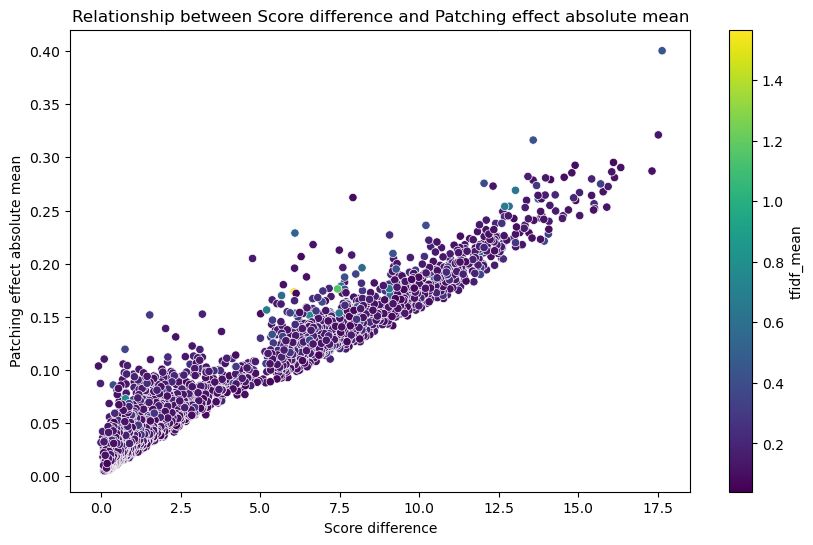

In [14]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_absolute_mean', 'tfidf_mean', all_data_pd, 'Relationship between Score difference and Patching effect absolute mean', 'Score difference', 'Patching effect absolute mean')    

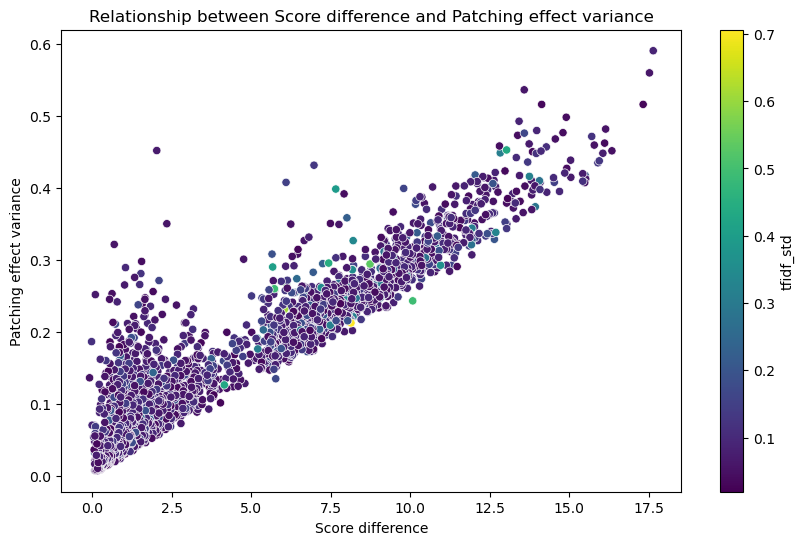

In [15]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'tfidf_std', all_data_pd, 'Relationship between Score difference and Patching effect variance', 'Score difference', 'Patching effect variance') 

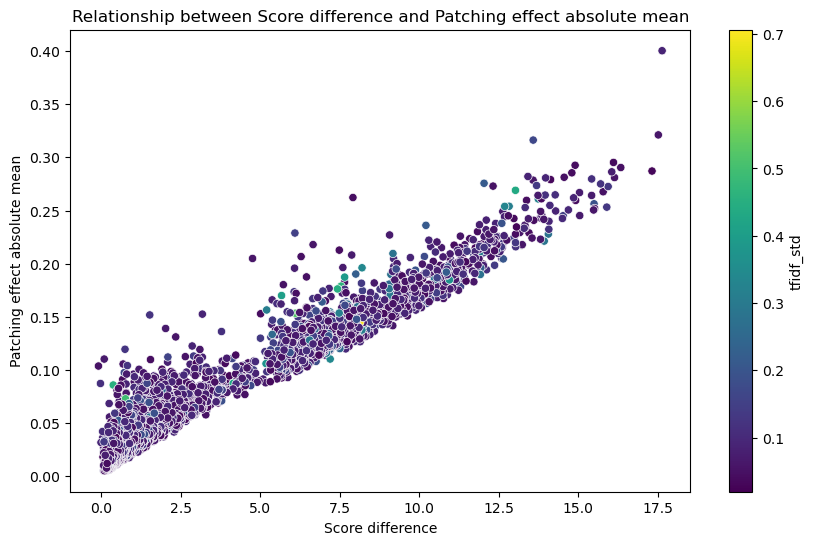

In [16]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_absolute_mean', 'tfidf_std', all_data_pd, 'Relationship between Score difference and Patching effect absolute mean', 'Score difference', 'Patching effect absolute mean')    

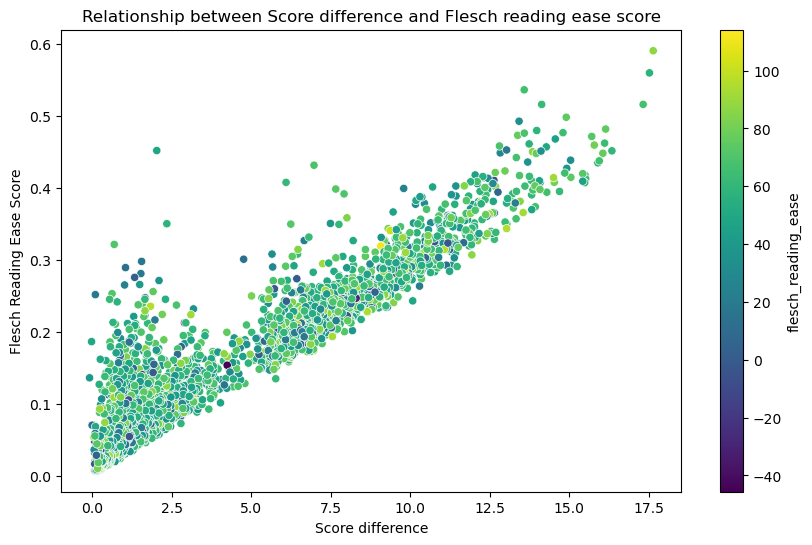

In [17]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'flesch_reading_ease', all_data_pd, 'Relationship between Score difference and Flesch reading ease score', 'Score difference', 'Flesch Reading Ease Score') 

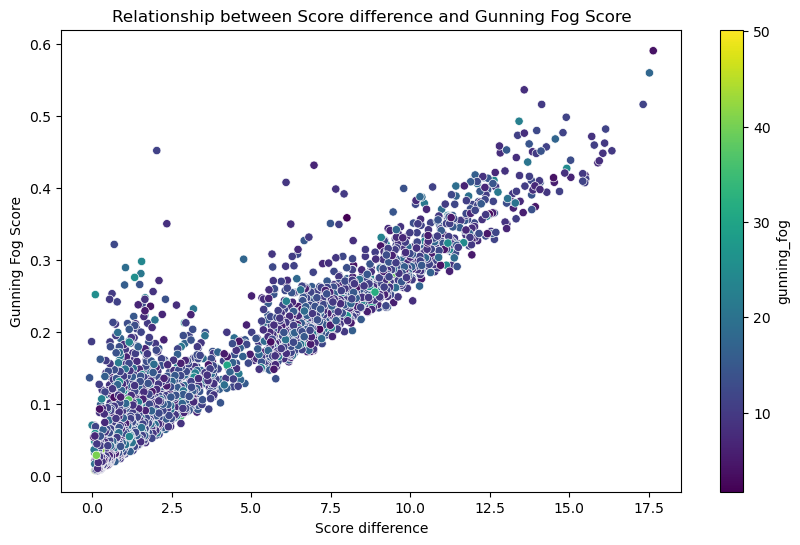

In [18]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'gunning_fog', all_data_pd, 'Relationship between Score difference and Gunning Fog Score', 'Score difference', 'Gunning Fog Score') 

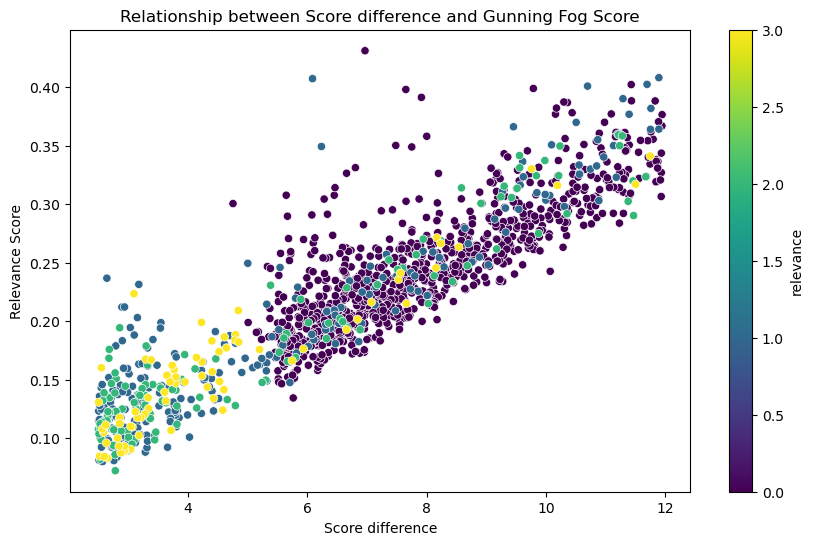

In [19]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'relevance', all_data_pd_scores_cut, 'Relationship between Score difference and Gunning Fog Score', 'Score difference', 'Relevance Score') 

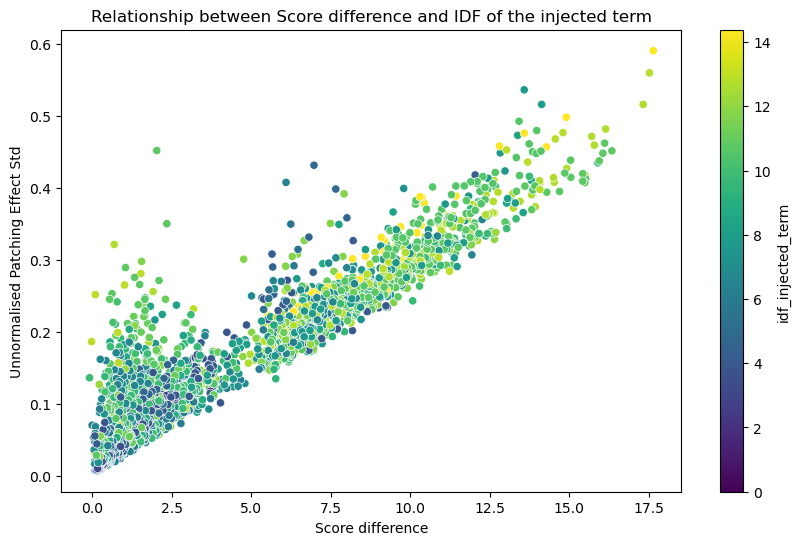

In [20]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'idf_injected_term', all_data_pd, 'Relationship between Score difference and IDF of the injected term', 'Score difference', 'Unnormalised Patching Effect Std') 

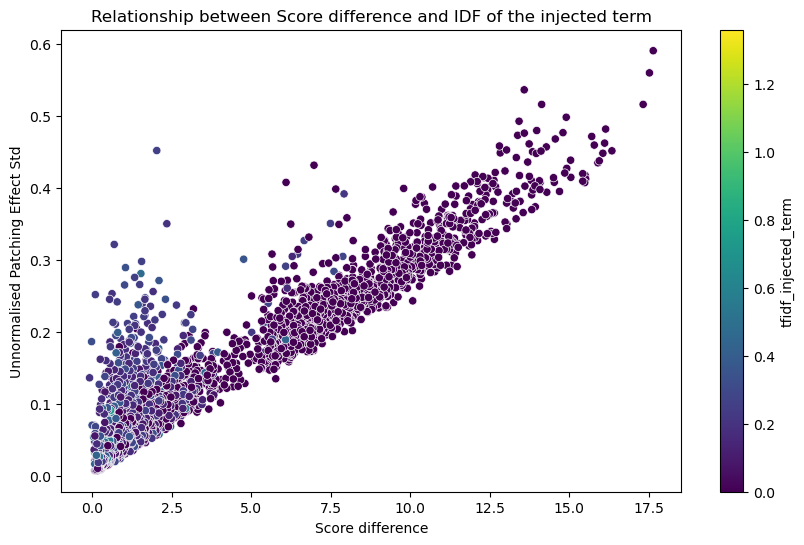

In [30]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'tfidf_injected_term', all_data_pd, 'Relationship between Score difference and IDF of the injected term', 'Score difference', 'Unnormalised Patching Effect Std') 

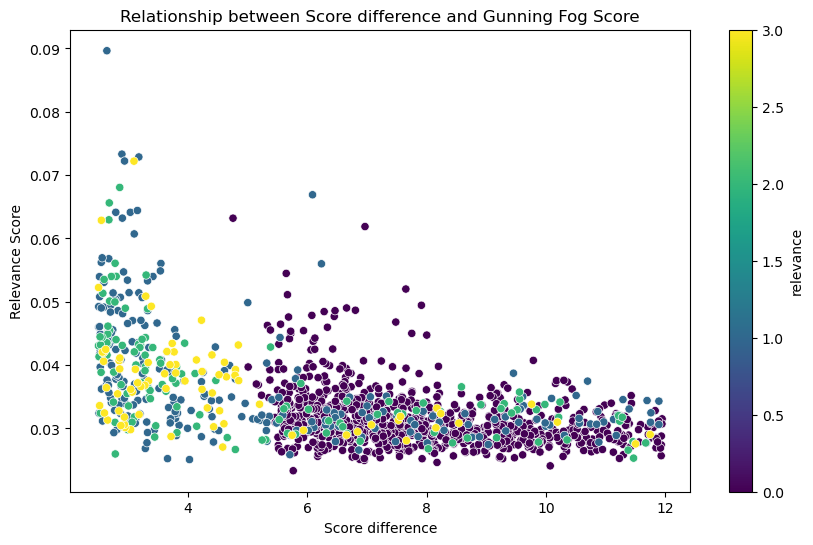

In [21]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_normalised_std', 'relevance', all_data_pd_scores_cut, 'Relationship between Score difference and Gunning Fog Score', 'Score difference', 'Relevance Score') 

Let's analyse correlations

In [51]:
all_data_pd.columns

Index(['qid', 'query', 'docno', 'text', 'relevance', 'perturbed',
       'perturbed_score', 'rank', 'original_score', 'score_delta',
       'perturbed_text', 'injected_term', 'text_doc', 'text_tokenized',
       'text_stemmed', 'tfidf_mean', 'tfidf_std', 'doc_length',
       'english_probability', 'num_sentences', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'gunning_fog', 'smog_index',
       'coleman_liau_index', 'automated_readability_index',
       'dale_chall_readability_score', 'gpt2_perplexity', 'query_id',
       'text_query', 'text_tokenized_query', 'text_stemmed_query',
       'tfidf_mean_query', 'tfidf_std_query', 'doc_length_query',
       'english_probability_query', 'flesch_reading_ease_query',
       'flesch_kincaid_grade_query', 'gunning_fog_query', 'smog_index_query',
       'coleman_liau_index_query', 'automated_readability_index_query',
       'dale_chall_readability_score_query', 'gpt2_perplexity_query',
       'idf_injected_term', 'tf_injected_term', 'tfid

In [31]:
def output_correlations(properties, target_metrics, data):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            spearman = spearmanr(data[property], data[target_metric])
            kendall = kendalltau(data[property], data[target_metric])
            correlations[target_metric][property] = {'spearman': np.round(spearman.correlation, 3), 
                                                     #'p-value-spearman': np.round(spearman.pvalue, 3),
                                                     'kendalltau': np.round(kendall.correlation, 3),}
                                                     #'p-value-kendalltau': np.round(kendall.pvalue, 3)}
    return pd.DataFrame(correlations)



# target_properties = ['score_delta', 'relevance', 'tokenized_doc_length', 'tokenized_query_length', 'original_score', 'perturbed_score', 'injected_term_exists']
# correlation_data = [{'target property': target_property, 
#                      'average absolute patching effect': all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman'),
#                      'average absolute patching effect (duplicate token heads)': all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')} for target_property in target_properties]

# target_metrics = ['patching_effect_normalised_std', 'patching_effect_normalised_absolute_mean',
#                   'patching_effect_normalised_square_std', 'patching_effect_normalised_square_absolute_mean', 
#                   'patching_effect_normalised_clip_std', 'patching_effect_normalised_clip_absolute_mean']

target_metrics = ['patching_effect_normalised_square_std', 'patching_effect_normalised_square_absolute_mean']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_correlations(properties, target_metrics, all_data_pd)
# correlations_table.rename(columns={'patching_effect_normalised_square_std': 'Std of Patching Effect (w/ Penalty)',
#                                    'patching_effect_normalised_square_absolute_mean': 'Mean Absolute Patching effect (w/ Penalty)'}, inplace=True)
correlations_table = correlations_table.sort_values(by='patching_effect_normalised_square_absolute_mean', key=lambda x: x.apply(lambda y: -np.abs(y['spearman'])))

/scratch_local/esx208-1140848/tmp/ipykernel_1614312/490284654.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(data[property], data[target_metric])


In [32]:
correlations_table

patching_effect_normalised_square_std  \
tfidf_injected_term                   {'spearman': 0.213, 'kendalltau': 0.155}   
tf_injected_term                      {'spearman': 0.112, 'kendalltau': 0.093}   
dale_chall_readability_score          {'spearman': 0.161, 'kendalltau': 0.107}   
coleman_liau_index_query               {'spearman': 0.03, 'kendalltau': 0.021}   
gpt2_perplexity                       {'spearman': 0.131, 'kendalltau': 0.087}   
automated_readability_index_query     {'spearman': 0.036, 'kendalltau': 0.023}   
flesch_reading_ease_query            {'spearman': -0.07, 'kendalltau': -0.047}   
tfidf_mean                            {'spearman': 0.124, 'kendalltau': 0.082}   
gunning_fog                           {'spearman': 0.097, 'kendalltau': 0.065}   
relevance                             {'spearman': 0.042, 'kendalltau': 0.044}   
smog_index                          {'spearman': -0.106, 'kendalltau': -0.074}   
automated_readability_index           {'spearman': 0.103, 'kendalltau': 0.069}   
english_probability_query           {'spearman': -0.095, 'kendalltau': -0.062}   
dale_chall_readability_score_query    {'spearman': 0.069, 'kendalltau': 0.046}   
score_delta                          {'spearman': 0.006, 'kendalltau': -0.024}   
coleman_liau_index                    {'spearman': 0.088, 'kendalltau': 0.058}   
flesch_reading_ease                 {'spearman': -0.066, 'kendalltau': -0.044}   
tfidf_mean_query                        {'spearman': 0.145, 'kendalltau': 0.1}   
gunning_fog_query                   {'spearman': -0.032, 'kendalltau': -0.023}   
gpt2_perplexity_query                 {'spearman': 0.067, 'kendalltau': 0.047}   
tfidf_std                             {'spearman': 0.009, 'kendalltau': 0.006}   
idf_injected_term                     {'spearman': 0.074, 'kendalltau': 0.052}   
english_probability                   {'spearman': 0.003, 'kendalltau': 0.002}   
tfidf_std_query                       {'spearman': 0.106, 'kendalltau': 0.072}   
smog_index_query                          {'spearman': nan, 'kendalltau': nan}   

                                   patching_effect_normalised_square_absolute_mean  
tfidf_injected_term                       {'spearman': 0.366, 'kendalltau': 0.276}  
tf_injected_term                          {'spearman': 0.264, 'kendalltau': 0.213}  
dale_chall_readability_score              {'spearman': 0.234, 'kendalltau': 0.158}  
coleman_liau_index_query                  {'spearman': 0.189, 'kendalltau': 0.129}  
gpt2_perplexity                           {'spearman': 0.182, 'kendalltau': 0.122}  
automated_readability_index_query         {'spearman': 0.179, 'kendalltau': 0.122}  
flesch_reading_ease_query               {'spearman': -0.163, 'kendalltau': -0.113}  
tfidf_mean                                {'spearman': 0.158, 'kendalltau': 0.106}  
gunning_fog                               {'spearman': 0.155, 'kendalltau': 0.104}  
relevance                                 {'spearman': 0.148, 'kendalltau': 0.125}  
smog_index                              {'spearman': -0.144, 'kendalltau': -0.101}  
automated_readability_index               {'spearman': 0.142, 'kendalltau': 0.095}  
english_probability_query               {'spearman': -0.135, 'kendalltau': -0.092}  
dale_chall_readability_score_query        {'spearman': 0.132, 'kendalltau': 0.091}  
score_delta                              {'spearman': -0.128, 'kendalltau': -0.12}  
coleman_liau_index                        {'spearman': 0.125, 'kendalltau': 0.083}  
flesch_reading_ease                     {'spearman': -0.107, 'kendalltau': -0.071}  
tfidf_mean_query                          {'spearman': 0.086, 'kendalltau': 0.054}  
gunning_fog_query                         {'spearman': 0.054, 'kendalltau': 0.039}  
gpt2_perplexity_query                      {'spearman': 0.05, 'kendalltau': 0.034}  
tfidf_std                               {'spearman': -0.014, 'kendalltau': -0.009}  
idf_injected_term                     

In [29]:
target_metrics = ['patching_effect_normalised_std', 'patching_effect_normalised_absolute_mean']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_correlations(properties, target_metrics, all_data_pd)
# correlations_table.rename(columns={'patching_effect_normalised_square_std': 'Std of Patching Effect (w/ Penalty)',
#                                    'patching_effect_normalised_square_absolute_mean': 'Mean Absolute Patching effect (w/ Penalty)'}, inplace=True)
correlations_table = correlations_table.sort_values(by='patching_effect_normalised_absolute_mean', key=lambda x: x.apply(lambda y: -np.abs(y['spearman'])))
correlations_table

/scratch_local/esx208-1140848/tmp/ipykernel_1614312/4101936924.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(data[property], data[target_metric])


patching_effect_normalised_std  \
score_delta                          {'spearman': -0.77, 'kendalltau': -0.565}   
relevance                             {'spearman': 0.622, 'kendalltau': 0.485}   
tfidf_injected_term                   {'spearman': 0.565, 'kendalltau': 0.427}   
tf_injected_term                      {'spearman': 0.551, 'kendalltau': 0.433}   
idf_injected_term                   {'spearman': -0.334, 'kendalltau': -0.227}   
coleman_liau_index_query              {'spearman': 0.153, 'kendalltau': 0.104}   
tfidf_std_query                      {'spearman': -0.17, 'kendalltau': -0.113}   
automated_readability_index_query      {'spearman': 0.132, 'kendalltau': 0.09}   
flesch_reading_ease_query           {'spearman': -0.162, 'kendalltau': -0.111}   
gunning_fog_query                     {'spearman': 0.109, 'kendalltau': 0.079}   
tfidf_mean_query                    {'spearman': -0.111, 'kendalltau': -0.078}   
english_probability_query           {'spearman': -0.102, 'kendalltau': -0.068}   
dale_chall_readability_score_query    {'spearman': 0.051, 'kendalltau': 0.033}   
dale_chall_readability_score          {'spearman': 0.051, 'kendalltau': 0.034}   
tfidf_std                           {'spearman': -0.057, 'kendalltau': -0.038}   
tfidf_mean                          {'spearman': -0.083, 'kendalltau': -0.055}   
gpt2_perplexity                       {'spearman': 0.035, 'kendalltau': 0.024}   
coleman_liau_index                    {'spearman': 0.028, 'kendalltau': 0.019}   
automated_readability_index           {'spearman': 0.027, 'kendalltau': 0.018}   
gunning_fog                           {'spearman': 0.012, 'kendalltau': 0.008}   
smog_index                            {'spearman': 0.048, 'kendalltau': 0.034}   
flesch_reading_ease                 {'spearman': -0.005, 'kendalltau': -0.003}   
english_probability                     {'spearman': 0.001, 'kendalltau': 0.0}   
gpt2_perplexity_query                 {'spearman': 0.004, 'kendalltau': 0.002}   
smog_index_query                          {'spearman': nan, 'kendalltau': nan}   

                                      patching_effect_normalised_absolute_mean  
score_delta                         {'spearman': -0.847, 'kendalltau': -0.651}  
relevance                             {'spearman': 0.675, 'kendalltau': 0.532}  
tfidf_injected_term                   {'spearman': 0.657, 'kendalltau': 0.502}  
tf_injected_term                      {'spearman': 0.651, 'kendalltau': 0.517}  
idf_injected_term                   {'spearman': -0.358, 'kendalltau': -0.245}  
coleman_liau_index_query              {'spearman': 0.247, 'kendalltau': 0.168}  
tfidf_std_query                      {'spearman': -0.23, 'kendalltau': -0.154}  
automated_readability_index_query     {'spearman': 0.216, 'kendalltau': 0.147}  
flesch_reading_ease_query            {'spearman': -0.21, 'kendalltau': -0.144}  
gunning_fog_query                     {'spearman': 0.166, 'kendalltau': 0.118}  
tfidf_mean_query                      {'spearman': -0.139, 'kendalltau': -0.1}  
english_probability_query             {'spearman': -0.13, 'kendalltau': -0.09}  
dale_chall_readability_score_query    {'spearman': 0.089, 'kendalltau': 0.059}  
dale_chall_readability_score          {'spearman': 0.087, 'kendalltau': 0.058}  
tfidf_std                           {'spearman': -0.073, 'kendalltau': -0.048}  
tfidf_mean                          {'spearman': -0.071, 'kendalltau': -0.047}  
gpt2_perplexity                       {'spearman': 0.056, 'kendalltau': 0.038}  
coleman_liau_index                    {'spearman': 0.049, 'kendalltau': 0.032}  
automated_readability_index           {'spearman': 0.047, 'kendalltau': 0.031}  
gunning_fog                           {'spearman': 0.042, 'kendalltau': 0.028}  
smog_index                            {'spearman': 0.033, 'kendalltau': 0.022}  
flesch_reading_ease                 {'spearman': -0.029, 'kendalltau': -0.019}  
english_probability                  {'spearman': -0

In [30]:
all_data_pd_scores_cut = all_data_pd[(all_data_pd['score_delta'] > 2.5) & (all_data_pd['score_delta'] < 12)]

target_metrics = ['patching_effect_normalised_square_std', 'patching_effect_normalised_square_absolute_mean']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table_scores_cut = output_correlations(properties, target_metrics, all_data_pd_scores_cut)
# correlations_table_scores_cut.rename(columns={'patching_effect_normalised_square_std': 'Std of Patching Effect (w/ Penalty)',
#                                                 'patching_effect_normalised_square_absolute_mean': 'Mean Absolute Patching effect (w/ Penalty)'}, inplace=True)
correlations_table_scores_cut = correlations_table_scores_cut.sort_values(by='patching_effect_normalised_square_absolute_mean', key=lambda x: x.apply(lambda y: -np.abs(y['spearman'])))

/scratch_local/esx208-1140848/tmp/ipykernel_1614312/4101936924.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(data[property], data[target_metric])


In [27]:
correlations_table_scores_cut

NameError: name 'correlations_table_scores_cut' is not defined

In [29]:
all_data_pd.columns

Index(['qid', 'query', 'docno', 'text', 'relevance', 'perturbed',
       'perturbed_score', 'rank', 'original_score', 'score_delta',
       'perturbed_text', 'injected_term', 'text_doc', 'text_tokenized',
       'text_stemmed', 'tfidf_mean', 'tfidf_std', 'doc_length',
       'english_probability', 'num_sentences', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'gunning_fog', 'smog_index',
       'coleman_liau_index', 'automated_readability_index',
       'dale_chall_readability_score', 'gpt2_perplexity', 'query_id',
       'text_query', 'text_tokenized_query', 'text_stemmed_query',
       'tfidf_mean_query', 'tfidf_std_query', 'doc_length_query',
       'english_probability_query', 'flesch_reading_ease_query',
       'flesch_kincaid_grade_query', 'gunning_fog_query', 'smog_index_query',
       'coleman_liau_index_query', 'automated_readability_index_query',
       'dale_chall_readability_score_query', 'gpt2_perplexity_query',
       'idf_injected_term', 'tf_injected_term', 'tfid

In [131]:
def output_partial_correlations(properties, target_metrics, data):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            if property != 'score_delta':
                spearman_partial = partial_corr(data=all_data_pd, x=target_metric, y=property, covar='score_delta', method='spearman')
                correlations[target_metric][property] = {'spearman_partial': np.round(spearman_partial['r'].values[0], 3), 
                                                        'p-value': np.round(spearman_partial['p-val'].values[0], 3)}
    return pd.DataFrame(correlations)


target_metrics = ['patching_effect_std', 'patching_effect_absolute_mean']

properties = ['score_delta', 'relevance', 'injected_term_token_len', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_partial_correlations(properties, target_metrics, all_data_pd)
correlations_table.rename(columns={'patching_effect_std': 'Std of Unnormalised Patching Effect',
                                   'patching_effect_absolute_mean': 'Mean Absolute Unnormalosed Patching effect'}, inplace=True)
correlations_table = correlations_table.sort_values(by='Std of Unnormalised Patching Effect', key=lambda x: x.apply(lambda y: -np.abs(y['spearman_partial'])))

/scratch_local/esx208-1160486/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1160486/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1160486/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1160486/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


In [132]:
correlations_table

Std of Unnormalised Patching Effect  \
idf_injected_term                      {'spearman_partial': 0.359, 'p-value': 0.0}   
injected_term_token_len                {'spearman_partial': 0.358, 'p-value': 0.0}   
tfidf_injected_term                    {'spearman_partial': 0.271, 'p-value': 0.0}   
tfidf_mean_query                       {'spearman_partial': 0.229, 'p-value': 0.0}   
tfidf_std_query                        {'spearman_partial': 0.208, 'p-value': 0.0}   
tf_injected_term                       {'spearman_partial': 0.177, 'p-value': 0.0}   
tfidf_mean                             {'spearman_partial': 0.134, 'p-value': 0.0}   
smog_index                            {'spearman_partial': -0.124, 'p-value': 0.0}   
gpt2_perplexity_query                  {'spearman_partial': 0.117, 'p-value': 0.0}   
english_probability_query             {'spearman_partial': -0.098, 'p-value': 0.0}   
dale_chall_readability_score           {'spearman_partial': 0.092, 'p-value': 0.0}   
gpt2_perplexity                        {'spearman_partial': 0.081, 'p-value': 0.0}   
gunning_fog_query                     {'spearman_partial': -0.066, 'p-value': 0.0}   
relevance                             {'spearman_partial': -0.062, 'p-value': 0.0}   
tfidf_std                              {'spearman_partial': 0.058, 'p-value': 0.0}   
coleman_liau_index_query            {'spearman_partial': -0.053, 'p-value': 0.001}   
coleman_liau_index                   {'spearman_partial': 0.052, 'p-value': 0.001}   
automated_readability_index           {'spearman_partial': 0.05, 'p-value': 0.002}   
flesch_reading_ease_query            {'spearman_partial': 0.047, 'p-value': 0.003}   
automated_readability_index_query   {'spearman_partial': -0.029, 'p-value': 0.067}   
gunning_fog                          {'spearman_partial': 0.019, 'p-value': 0.233}   
dale_chall_readability_score_query   {'spearman_partial': 0.013, 'p-value': 0.403}   
flesch_reading_ease                 {'spearman_partial': -0.012, 'p-value': 0.439}   
english_probability                 {'spearman_partial': -0.006, 'p-value': 0.721}   
smog_index_query                         {'spearman_partial': nan, 'p-value': nan}   

                                        Mean Absolute Unnormalosed Patching effect  
idf_injected_term                      {'spearman_partial': 0.388, 'p-value': 0.0}  
injected_term_token_len                {'spearman_partial': 0.434, 'p-value': 0.0}  
tfidf_injected_term                    {'spearman_partial': 0.364, 'p-value': 0.0}  
tfidf_mean_query                       {'spearman_partial': 0.247, 'p-value': 0.0}  
tfidf_std_query                        {'spearman_partial': 0.185, 'p-value': 0.0}  
tf_injected_term                       {'spearman_partial': 0.262, 'p-value': 0.0}  
tfidf_mean                              {'spearman_partial': 0.21, 'p-value': 0.0}  
smog_index                            {'spearman_partial': -0.183, 'p-value': 0.0}  
gpt2_perplexity_query                  {'spearman_partial': 0.114, 'p-value': 0.0}  
english_probability_query             {'spearman_partial': -0.143, 'p-value': 0.0}  
dale_chall_readability_score           {'spearman_partial': 0.159, 'p-value': 0.0}  
gpt2_perplexity                        {'spearman_partial': 0.134, 'p-value': 0.0}  
gunning_fog_query                   {'spearman_partial': -0.007, 'p-value': 0.638}  
relevance                             {'spearman_partial': -0.063, 'p-value': 0.0}  
tfidf_std                               {'spearman_partial': 0.07, 'p-value': 0.0}  
coleman_liau_index_query              {'spearman_partial': 0.04, 'p-value': 0.012}  
coleman_liau_index                     {'spearman_partial': 0.087, 'p-value': 0.0}  
automated_readability_index            {'spearman_partial': 0.086, 'p-value': 0.0}  
flesch_reading_ease_query           {'spearman_partial': -0.018, 'p-value': 0.263}  
automated_readability_index_query    {'spearman_partial': 0.055, 'p-value': 0.001}  
gunning_fog              

In [133]:
target_metrics = ['gini']

properties = ['score_delta', 'relevance', 'injected_term_token_len', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_partial_correlations(properties, target_metrics, all_data_pd)
correlations_table = correlations_table.sort_values(by='gini', key=lambda x: x.apply(lambda y: -np.abs(y['spearman_partial'])))

/scratch_local/esx208-1160486/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1160486/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


In [134]:
correlations_table

gini
tfidf_injected_term                   {'spearman_partial': -0.345, 'p-value': 0.0}
tf_injected_term                      {'spearman_partial': -0.322, 'p-value': 0.0}
injected_term_token_len               {'spearman_partial': -0.243, 'p-value': 0.0}
coleman_liau_index_query              {'spearman_partial': -0.233, 'p-value': 0.0}
automated_readability_index_query     {'spearman_partial': -0.205, 'p-value': 0.0}
idf_injected_term                      {'spearman_partial': -0.18, 'p-value': 0.0}
dale_chall_readability_score          {'spearman_partial': -0.174, 'p-value': 0.0}
flesch_reading_ease_query              {'spearman_partial': 0.152, 'p-value': 0.0}
gpt2_perplexity                       {'spearman_partial': -0.149, 'p-value': 0.0}
gunning_fog_query                     {'spearman_partial': -0.145, 'p-value': 0.0}
tfidf_mean                            {'spearman_partial': -0.143, 'p-value': 0.0}
gunning_fog                           {'spearman_partial': -0.129, 'p-value': 0.0}
dale_chall_readability_score_query    {'spearman_partial': -0.119, 'p-value': 0.0}
smog_index                             {'spearman_partial': 0.106, 'p-value': 0.0}
flesch_reading_ease                    {'spearman_partial': 0.106, 'p-value': 0.0}
automated_readability_index           {'spearman_partial': -0.098, 'p-value': 0.0}
coleman_liau_index                     {'spearman_partial': -0.09, 'p-value': 0.0}
relevance                             {'spearman_partial': -0.064, 'p-value': 0.0}
tfidf_std_query                      {'spearman_partial': 0.049, 'p-value': 0.002}
gpt2_perplexity_query                {'spearman_partial': 0.038, 'p-value': 0.015}
english_probability                  {'spearman_partial': 0.033, 'p-value': 0.035}
english_probability_query            {'spearman_partial': 0.026, 'p-value': 0.102}
tfidf_std                            {'spearman_partial': 0.011, 'p-value': 0.498}
tfidf_mean_query                    {'spearman_partial': -0.007, 'p-value': 0.658}
smog_index_query                         {'spearman_partial': nan, 'p-value': nan}

In [11]:
def train_catboost_model(df, target_column, feature_columns):
    X = df[feature_columns]
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        early_stopping_rounds=20,
        verbose=100
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=True
    )
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance,
        'predictions': y_pred
    }

In [12]:
len(properties)

NameError: name 'properties' is not defined

In [63]:
results = train_catboost_model(all_data_pd, 'patching_effect_normalised_square_std', properties)

TBB Warning: The number of workers is currently limited to 7. The request for 71 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0199850	test: 0.0196905	best: 0.0196905 (0)	total: 50.6ms	remaining: 50.5s
100:	learn: 0.0103054	test: 0.0128497	best: 0.0128465 (98)	total: 217ms	remaining: 1.93s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.01257955088
bestIteration = 141

Shrink model to first 142 iterations.


In [64]:
results

{'model': <catboost.core.CatBoostRegressor at 0x7f2085ac7d60>,
 'rmse': 0.012579550883629822,
 'r2': 0.6205939552089992,
 'feature_importance':                                feature  importance
 2                  tfidf_injected_term   22.963750
 4                     tf_injected_term   15.991013
 0                          score_delta   15.738057
 3                    idf_injected_term   10.265720
 16                     tfidf_std_query    3.811184
 19                   gunning_fog_query    3.739200
 15                    tfidf_mean_query    3.446183
 18           flesch_reading_ease_query    2.687122
 24               gpt2_perplexity_query    2.619254
 6                            tfidf_std    2.172182
 14                     gpt2_perplexity    1.930090
 11                  coleman_liau_index    1.718402
 5                           tfidf_mean    1.646672
 17           english_probability_query    1.510768
 21            coleman_liau_index_query    1.489179
 1                       

In [65]:
results_mean = train_catboost_model(all_data_pd, 'patching_effect_normalised_square_absolute_mean', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0085222	test: 0.0078749	best: 0.0078749 (0)	total: 3.98ms	remaining: 3.98s
100:	learn: 0.0040778	test: 0.0046461	best: 0.0046458 (99)	total: 169ms	remaining: 1.5s
200:	learn: 0.0032000	test: 0.0045029	best: 0.0045029 (200)	total: 321ms	remaining: 1.28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.004460983074
bestIteration = 246

Shrink model to first 247 iterations.


In [66]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f228cf74cd0>,
 'rmse': 0.004460983073914318,
 'r2': 0.7029154449224932,
 'feature_importance':                                feature  importance
 2                  tfidf_injected_term   22.302131
 0                          score_delta   19.215207
 4                     tf_injected_term   12.563233
 3                    idf_injected_term    9.516428
 16                     tfidf_std_query    5.900770
 15                    tfidf_mean_query    3.616091
 14                     gpt2_perplexity    2.775461
 5                           tfidf_mean    2.333954
 1                            relevance    2.329185
 6                            tfidf_std    2.221033
 19                   gunning_fog_query    2.189701
 10                          smog_index    1.732509
 13        dale_chall_readability_score    1.645724
 8                  flesch_reading_ease    1.481800
 21            coleman_liau_index_query    1.305451
 24               gpt2_pe

In [ ]:
results_unpenalised_std = train_catboost_model(all_data_pd, 'patching_effect_normalised_std', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1706382	test: 0.0392695	best: 0.0392695 (0)	total: 2.02ms	remaining: 2.02s
100:	learn: 0.0282238	test: 0.0285289	best: 0.0285155 (99)	total: 160ms	remaining: 1.43s
200:	learn: 0.0177523	test: 0.0260129	best: 0.0260117 (199)	total: 325ms	remaining: 1.29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.02590303271
bestIteration = 221

Shrink model to first 222 iterations.


In [17]:
results_unpenalised_std

{'model': <catboost.core.CatBoostRegressor at 0x7f2754b25c40>,
 'rmse': 0.031662089468544506,
 'r2': 0.34277265551117375,
 'feature_importance':                                feature  importance
 0                          score_delta   58.056152
 11                     gpt2_perplexity   28.501551
 14           english_probability_query    2.267724
 20  dale_chall_readability_score_query    1.991138
 12                    tfidf_mean_query    1.375217
 2                           tfidf_mean    0.912758
 5                  flesch_reading_ease    0.863257
 3                            tfidf_std    0.850104
 6                          gunning_fog    0.636776
 8                   coleman_liau_index    0.603851
 15           flesch_reading_ease_query    0.544712
 19   automated_readability_index_query    0.527633
 13                     tfidf_std_query    0.479196
 9          automated_readability_index    0.464075
 1                            relevance    0.447700
 16                   gu

In [18]:
results_unpenalised_mean = train_catboost_model(all_data_pd, 'patching_effect_normalised_absolute_mean', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0824945	test: 0.0188195	best: 0.0188195 (0)	total: 1.62ms	remaining: 1.62s
100:	learn: 0.0127607	test: 0.0123583	best: 0.0123458 (93)	total: 146ms	remaining: 1.3s
200:	learn: 0.0085533	test: 0.0118882	best: 0.0118637 (177)	total: 296ms	remaining: 1.18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01185504589
bestIteration = 223

Shrink model to first 224 iterations.


In [19]:
results_unpenalised_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f2754aec0a0>,
 'rmse': 0.011855045892987939,
 'r2': 0.5699887740704268,
 'feature_importance':                                feature  importance
 0                          score_delta   58.395825
 11                     gpt2_perplexity   21.992006
 2                           tfidf_mean    2.820887
 3                            tfidf_std    2.317517
 12                    tfidf_mean_query    2.074090
 5                  flesch_reading_ease    1.843968
 1                            relevance    1.112117
 13                     tfidf_std_query    1.095273
 9          automated_readability_index    1.077050
 8                   coleman_liau_index    0.927618
 21               gpt2_perplexity_query    0.899691
 20  dale_chall_readability_score_query    0.808350
 14           english_probability_query    0.786253
 10        dale_chall_readability_score    0.686920
 16                   gunning_fog_query    0.639033
 6                       

In [20]:
results_clipped_std = train_catboost_model(all_data_pd, 'patching_effect_normalised_clip_std', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0478534	test: 0.0307867	best: 0.0307867 (0)	total: 1.77ms	remaining: 1.77s
100:	learn: 0.0200971	test: 0.0223267	best: 0.0223033 (94)	total: 155ms	remaining: 1.38s
200:	learn: 0.0155716	test: 0.0220058	best: 0.0220058 (200)	total: 306ms	remaining: 1.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.02198681949
bestIteration = 202

Shrink model to first 203 iterations.


In [21]:
results_clipped_std

{'model': <catboost.core.CatBoostRegressor at 0x7f27548cc940>,
 'rmse': 0.021986819494406173,
 'r2': 0.5108218472073471,
 'feature_importance':                                feature  importance
 0                          score_delta   49.740670
 2                           tfidf_mean    5.167590
 12                    tfidf_mean_query    4.087504
 13                     tfidf_std_query    3.632526
 14           english_probability_query    3.585523
 11                     gpt2_perplexity    3.456010
 16                   gunning_fog_query    3.386017
 3                            tfidf_std    3.313264
 7                           smog_index    2.930010
 1                            relevance    2.859148
 15           flesch_reading_ease_query    2.642261
 8                   coleman_liau_index    2.512906
 19   automated_readability_index_query    2.114086
 21               gpt2_perplexity_query    1.877904
 20  dale_chall_readability_score_query    1.756804
 10        dale_chall_rea

In [22]:
results_clipped_mean = train_catboost_model(all_data_pd, 'patching_effect_normalised_clip_absolute_mean', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0354838	test: 0.0168016	best: 0.0168016 (0)	total: 2.76ms	remaining: 2.76s
100:	learn: 0.0096467	test: 0.0102035	best: 0.0102035 (100)	total: 186ms	remaining: 1.66s
200:	learn: 0.0070349	test: 0.0098719	best: 0.0098538 (183)	total: 340ms	remaining: 1.35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.009853803044
bestIteration = 183

Shrink model to first 184 iterations.


In [23]:
results_clipped_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f2754356bb0>,
 'rmse': 0.009853803044270821,
 'r2': 0.6656250790588297,
 'feature_importance':                                feature  importance
 0                          score_delta   55.484492
 2                           tfidf_mean    8.019272
 7                           smog_index    4.916097
 14           english_probability_query    4.657553
 20  dale_chall_readability_score_query    3.395257
 11                     gpt2_perplexity    2.834071
 8                   coleman_liau_index    2.675571
 3                            tfidf_std    2.238460
 12                    tfidf_mean_query    2.147549
 18            coleman_liau_index_query    1.904338
 1                            relevance    1.835806
 13                     tfidf_std_query    1.677475
 21               gpt2_perplexity_query    1.569686
 10        dale_chall_readability_score    1.361456
 9          automated_readability_index    1.062223
 5                  flesc

In [34]:
all_data_pd.sort_values(by='tfidf_injected_term')

qid                                            query    docno  \
3241   673670                                    what is a alm  7257301   
1714   148538                    difference between rn and bsn  6485504   
1715   451602  medicare's definition of mechanical ventilation  4798722   
3347  1112341            what is the daily life of thai people  1702898   
3356   183378                         exons definition biology  6247405   
...       ...                                              ...      ...   
2543   135802                           definition of laudable  8692621   
3580  1030303                               who is aziz hashim  8726436   
3970  1127540                               meaning of shebang  8726954   
3955  1112341            what is the daily life of thai people  4595993   
3945  1127540                               meaning of shebang  8726956   

                                                   text  relevance  perturbed  \
3241  Define alms: something (such as money or food)...          3       True   
1714  Money is always a motivator. The pay increase ...          1       True   
1715  The breathing tube is a common name for the ET...          1       True   
3347  The Thai Baht is the currency in Thailand (TH,...          3       True   
3356  A segment of DNA that codes for a protein is c...          3       True   
...                                                 ...        ...        ...   
2543  One of Emma's less laudable characteristics wa...          2       True   
3580  Share on LinkedInShare on FacebookShare on Twi...          3       True   
3970  Shebang is slang for a situation, or a set of ...          3       True   
3955  Muay Thai. Muay Thai (Thai: มวยไทย, rtgs: Muai...          3       True   
3945  Shebang is slang for a situation, or a set of ...          3       True   

      perturbed_score  rank  original_score  score_delta  ...  \
3241        99.950081    46       98.609764     1.340317  ...   
1714       100.426552   174       99.078644     1.347908  ...   
1715        93.777069   212       92.560738     1.216331  ...   
3347        89.809624   266       88.894920     0.914703  ...   
3356       100.332085    65       99.439705     0.892380  ...   
...               ...   ...             ...          ...  ...   
2543       100.744919    15      100.344795     0.400124  ...   
3580       100.415627    29      100.010284     0.405342  ...   
3970       105.703232    10      105.494507     0.208725  ...   
3955        92.280220   143       92.066635     0.213585  ...   
3945       106.031136     6      105.882484     0.148651  ...   

     tf_injected_term tfidf_injected_term patching_effect_std  \
3241                0            0.000000            0.055878   
1714                0            0.000000            0.072467   
1715                0            0.000000            0.038827   
3347                0            0.000000            0.035308   
3356                0            0.000000            0.060595   
...               ...                 ...                 ...   
2543                3            1.004429            0.066954   
3580                4            1.156653            0.070161   
3970                4            1.188413            0.022295   
3955                5            1.345881            0.012662   
3945                4            1.358186            0.021526   

     patching_effect_absolute_mean patching_effect_normalised_std  \
3241                      0.037369                       0.041690   
1714                      0.046063                       0.053762   
1715                      0.031561                       0.031921   
3347                      0.022477                       0.038601   
3356                      0.041611                       0.067903   
...                            ...                            ...   
2543                      0.044824                       0.167333   
3580                  

In [22]:
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                      np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))

In [24]:
all_data_pd.sort_values(by='tfidf_injected_term', ascending=False).head(10)

qid                                  query    docno  \
3945  1127540                     meaning of shebang  8726956   
3955  1112341  what is the daily life of thai people  4595993   
3970  1127540                     meaning of shebang  8726954   
3580  1030303                     who is aziz hashim  8726436   
2543   135802                 definition of laudable  8692621   
3615   183378               exons definition biology  4727412   
3908   131843                 definition of a sigmet   985994   
2499   135802                 definition of laudable  8692622   
3688  1127540                     meaning of shebang  8726958   
3523   183378               exons definition biology  5534711   

                                                   text  relevance  perturbed  \
3945  Shebang is slang for a situation, or a set of ...          3       True   
3955  Muay Thai. Muay Thai (Thai: มวยไทย, rtgs: Muai...          3       True   
3970  Shebang is slang for a situation, or a set of ...          3       True   
3580  Share on LinkedInShare on FacebookShare on Twi...          3       True   
2543  One of Emma's less laudable characteristics wa...          2       True   
3615  Transcrition/translation - Exons and introns. ...          3       True   
3908  sigmet SIGMET, or Significant Meteorological I...          3       True   
2499  Times, Sunday Times (2010)It may be laudable b...          2       True   
3688  shebang. 1  Informal. the structure of somethi...          3       True   
3523  Introns and exons are parts of genes. Exons co...          3       True   

      perturbed_score  rank  original_score  score_delta  ...  \
3945       106.031136     6      105.882484     0.148651  ...   
3955        92.280220   143       92.066635     0.213585  ...   
3970       105.703232    10      105.494507     0.208725  ...   
3580       100.415627    29      100.010284     0.405342  ...   
2543       100.744919    15      100.344795     0.400124  ...   
3615        97.668129   162       97.350212     0.317917  ...   
3908       105.149048     6      105.075256     0.073792  ...   
2499        97.001480    34       96.340935     0.660545  ...   
3688       105.461678    12      104.948822     0.512856  ...   
3523        99.527992    92       98.826851     0.701141  ...   

     tfidf_injected_term injected_term_token_len patching_effect_std  \
3945            1.358186                       2            0.021526   
3955            1.345881                       1            0.012662   
3970            1.188413                       2            0.022295   
3580            1.156653                       2            0.070161   
2543            1.004429                       2            0.066954   
3615            0.890224                       2            0.045744   
3908            0.883928                       3            0.031362   
2499            0.857439                       2            0.052978   
3688            0.819595                       2            0.051591   
3523            0.799385                       2            0.029553   

     patching_effect_absolute_mean patching_effect_normalised_std  \
3945                      0.015606                       0.144807   
3955                      0.009723                       0.059284   
3970                      0.016207                       0.106815   
3580                      0.049513                       0.173090   
2543                      0.044824                       0.167333   
3615                      0.030898                       0.143886   
3908                      0.023288                       0.425004   
2499                      0.041034                       0.080203   
3688                      0.030304                       0.100596   
3523                      0.025723                       0.042150   

      patching_effect_normalised_absolute_mean  \
3945                                  0.104987   
3955                             

In [35]:
all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(100)

qid                       query    docno  \
423   855410  what is theraderm used for  5021348   
168   855410  what is theraderm used for   510943   
66    855410  what is theraderm used for  4354935   
323   855410  what is theraderm used for  7137616   
315   855410  what is theraderm used for  1365235   
...      ...                         ...      ...   
1028  131843      definition of a sigmet   988472   
3285  131843      definition of a sigmet  8710813   
1034  131843      definition of a sigmet  4751877   
228   131843      definition of a sigmet   202309   
1040  131843      definition of a sigmet  8305157   

                                                   text  relevance  perturbed  \
423   Reinforcing skincare with cream-based products...          0       True   
168   Still, a cream will always be your first choic...          0       True   
66    Applications: 1  Used in diagnostic laboratori...          0       True   
323   WebMD experts and contributors provide answers...          0       True   
315   A system that allows people or companies to bu...          0       True   
...                                                 ...        ...        ...   
1028  Note that a watch is not required for a warnin...          1       True   
3285  Definition of AIRMET. plural. AIRMETs. also. a...          3       True   
1034  Forecast Discussion. SPC AC 160543 Day 2 Conve...          1       True   
228   Aviation Glossary :: Aerobatic. Welcome to the...          0       True   
1040  An AIRMET, or Airmen's Meteorological Informat...          1       True   

      perturbed_score  rank  original_score  score_delta  ...  \
423         94.255013    34       86.325607     7.929405  ...   
168         93.970551    40       83.529861    10.440689  ...   
66          99.784088     6       86.981903    12.802185  ...   
323         96.940117    15       86.729874    10.210243  ...   
315         91.951378    65       82.697769     9.253609  ...   
...               ...   ...             ...          ...  ...   
1028        92.789040    61       81.582314    11.206726  ...   
3285        97.968338    28       97.140785     0.827553  ...   
1034        90.375961    76       79.405869    10.970093  ...   
228         93.905998    54       84.533508     9.372490  ...   
1040        99.712730    21       88.823715    10.889015  ...   

     tfidf_injected_term injected_term_token_len patching_effect_std  \
423              0.00000                       3            0.259684   
168              0.00000                       3            0.378136   
66               0.00000                       3            0.457816   
323              0.00000                       3            0.337309   
315              0.00000                       3            0.257740   
...                  ...                     ...                 ...   
1028             0.00000                       3            0.359862   
3285             0.32864                       3            0.110986   
1034             0.00000                       3            0.340308   
228              0.00000                       3            0.279584   
1040             0.00000                       3            0.303058   

     patching_effect_absolute_mean patching_effect_normalised_std  \
423                       0.148202                       0.032750   
168                       0.202166                       0.036218   
66                        0.245073                       0.035761   
323                       0.236090                       0.033036   
315                       0.168515                       0.027853   
...                            ...                            ...   
1028                      0.212569                       0.032111   
3285                      0.068176                       0.134114   
1034                      0.209230                       0.031021   
228                       0.180609                       0.0298

<Axes: >

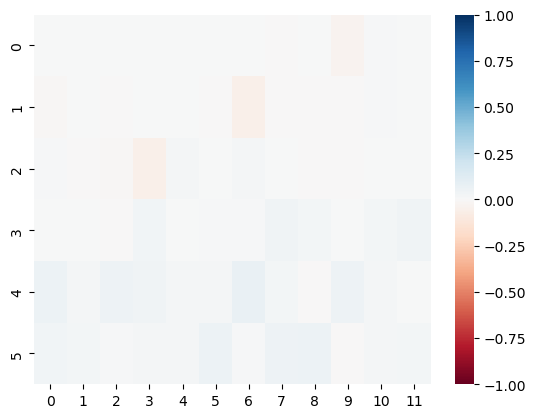

In [33]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='tfidf_mean_query', ascending=False).head(1000).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

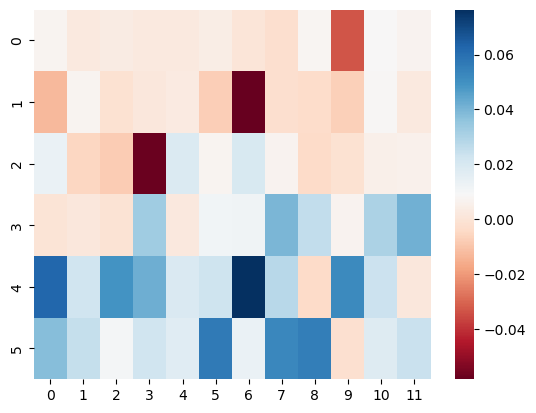

In [36]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='tfidf_mean_query', ascending=False).head(1000).index].mean(axis=0),
    cmap='RdBu'
)

<Axes: >

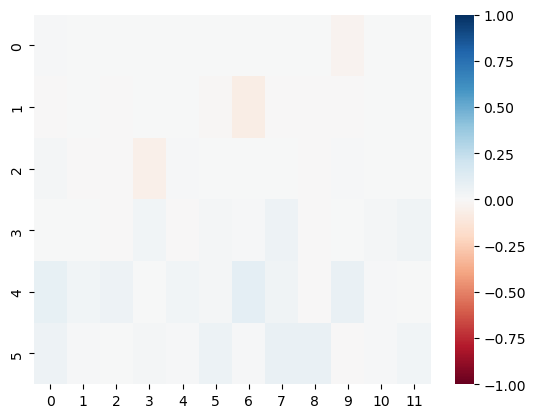

In [34]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(1000).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

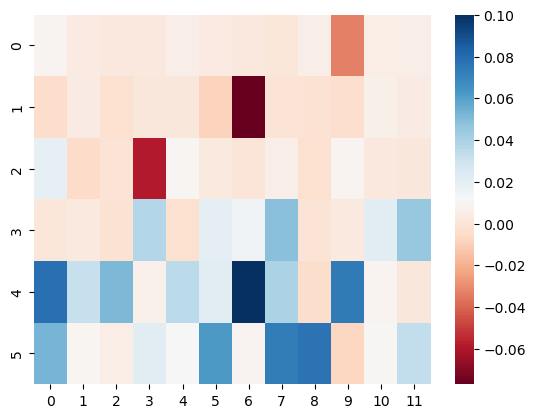

In [37]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(1000).index].mean(axis=0),
    cmap='RdBu'
)

<Axes: >

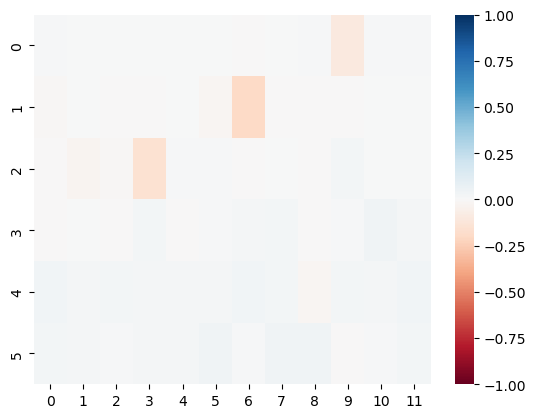

In [43]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='tfidf_injected_term', ascending=False).head(1000).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

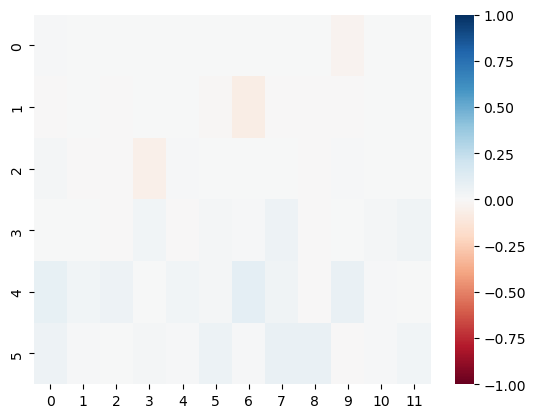

In [56]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(1000).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

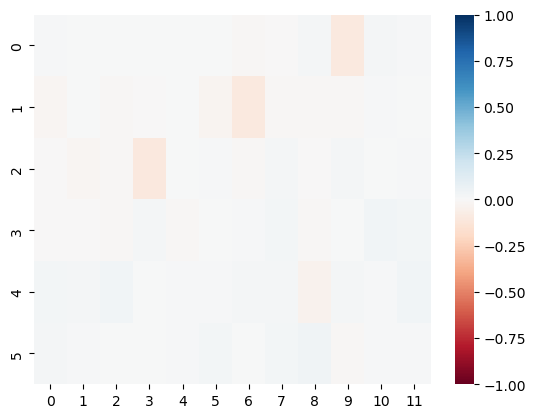

In [52]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='tfidf_injected_term', ascending=False).head(100).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

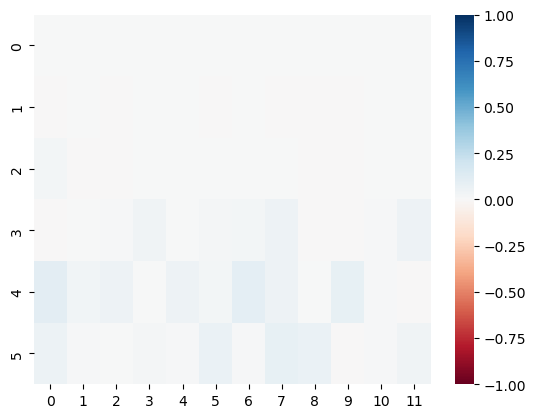

In [57]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='score_delta', ascending=False).head(1000).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

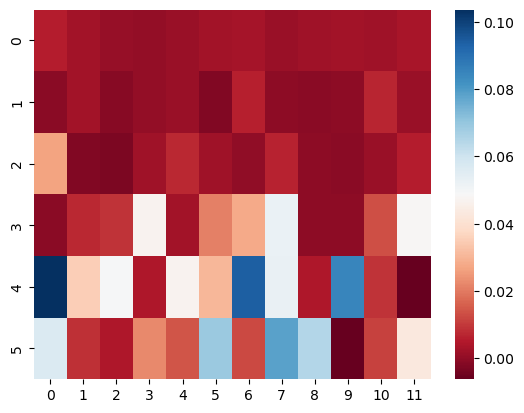

In [38]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='score_delta', ascending=False).head(1000).index].mean(axis=0),
    cmap='RdBu'
)

<Axes: >

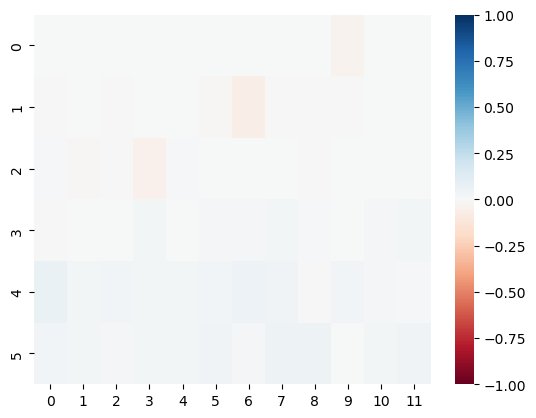

In [29]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='score_delta', ascending=False).head(4000).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

In [59]:
all_data_pd.sort_values(by='score_delta', ascending=False).head(1000)

qid                                              query    docno  \
3     855410                         what is theraderm used for  8751749   
0     768208                                      what is mamey  3186011   
1     768208                                      what is mamey  6835292   
5     583468                           what carvedilol used for  7790401   
2     768208                                      what is mamey  8041502   
..       ...                                                ...      ...   
861  1131069                     how many sons robert kraft has  6863839   
840  1110678                                 what is the un fao  3854406   
859  1115210                            what is chaff and flare  4267676   
819   146187  difference between a mcdouble and a double che...  6447372   
858   156498                           do google docs auto save  6602770   

                                                  text  relevance  perturbed  \
3    : to add moisture to (something, such as a per...          0       True   
0    This species has an elongated oblong narrow sh...          0       True   
1    Their size and excellent color retention prope...          0       True   
5    Writing things down will make managing your me...          0       True   
2    ‘I have a friend who is selling a product that...          0       True   
..                                                 ...        ...        ...   
861  How Son of Sam Changed America. David Berkowit...          0       True   
840  International Monetary Fund (IMF) is sometimes...          0       True   
859  Pains in my shoulder and shooting down my arm....          0       True   
819  Cheeseburger w/onion-Protein Style (100% pure ...          0       True   
858  To automatically approve revisions to updates....          0       True   

     perturbed_score  rank  original_score  score_delta  ... tf_injected_term  \
3          99.954689     4       82.315582    17.639107  ...                0   
0         100.175987    15       82.655556    17.520432  ...                0   
1          96.847061    43       79.524940    17.322121  ...                0   
5         100.040550   223       83.701126    16.339424  ...                0   
2          95.648750    53       79.505974    16.142776  ...                0   
..               ...   ...             ...          ...  ...              ...   
861        95.091667   105       88.932137     6.159531  ...                0   
840        97.481575    54       91.324501     6.157074  ...                0   
859        85.760391   316       79.605286     6.155106  ...                0   
819        98.265015    45       92.111351     6.153664  ...                0   
858        89.946266   298       83.792656     6.153610  ...                0   

    tfidf_injected_term patching_effect_std patching_effect_absolute_mean  \
3                   0.0            0.590199                      0.400308   
0                   0.0            0.559431                      0.321137   
1                   0.0            0.515633                      0.287155   
5                   0.0            0.451129                      0.290448   
2                   0.0            0.481380                      0.281040   
..                  ...                 ...                           ...   
861                 0.0            0.203885                      0.114028   
840                 0.0            0.192709                      0.105952   
859                 0.0            0.189872                      0.101264   
819                 0.0            0.204585                      0.132201   
858                 0.0            0.182761                      0.118654   

    patching_effect_normalised_std  patching_effect_normalised_absolute_mean  \
3                         0.033460                                  0.022694   
0                         0.031930                                  0.018329 

Let's try to decorrelate the target metric with the score difference

In [13]:
properties = ['score_delta', 'relevance', 'injected_term_token_len', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']

In [17]:
from sklearn.linear_model import LinearRegression

def decorrelate_columns(df, target_col, feature_col, new_col_name=None):
    if new_col_name is None:
        new_col_name = f"{target_col}_decorrelated"

    model = LinearRegression()
    X = df[[feature_col]].values.reshape(-1, 1)
    y = df[target_col].values
    model.fit(X, y)

    predicted = model.predict(X)

    df[new_col_name] = df[target_col] - predicted

    print(f"Correlation before: {df[target_col].corr(df[feature_col]):.4f}")
    print(f"Correlation after: {df[new_col_name].corr(df[feature_col]):.4f}")

    return df

In [14]:
def train_catboost_model(df, target_column, feature_columns):
    X = df[feature_columns]
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        early_stopping_rounds=20,
        verbose=100
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=True
    )
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance,
        'predictions': y_pred
    }

In [19]:
decorrelate_columns(all_data_pd, 'patching_effect_absolute_mean', 'score_delta', new_col_name='patching_effect_absolute_mean_decorrelated')
decorrelate_columns(all_data_pd, 'patching_effect_std', 'score_delta', new_col_name='patching_effect_std_decorrelated')

Correlation before: 0.9679
Correlation after: -0.0000
Correlation before: 0.9435
Correlation after: -0.0000


qid                                              query    docno  \
0      768208                                      what is mamey  3186011   
1      768208                                      what is mamey  6835292   
2      768208                                      what is mamey  8041502   
3      855410                         what is theraderm used for  8751749   
4      121171                                   define etruscans  7409541   
...       ...                                                ...      ...   
3995   451602    medicare's definition of mechanical ventilation  6286982   
3996  1136962  why did the ancient egyptians call their land ...   596001   
3997   258062       how long does it take to remove wisdom tooth  4174313   
3998   583468                           what carvedilol used for  7491704   
3999  1129237        hydrogen is a liquid below what temperature   128982   

                                                   text  relevance  perturbed  \
0     This species has an elongated oblong narrow sh...          0       True   
1     Their size and excellent color retention prope...          0       True   
2     ‘I have a friend who is selling a product that...          0       True   
3     : to add moisture to (something, such as a per...          0       True   
4     Fully accessible PDF installation guide, and a...          0       True   
...                                                 ...        ...        ...   
3995  Mechanical ventilation is indicated when the p...          3       True   
3996  The ancient Egyptian name as transliterated fr...          3       True   
3997  The time it takes to remove the tooth will var...          3       True   
3998  what carvedilol is and what it is used for car...          3       True   
3999  Gas. For hydrogen to become a liquid, you need...          3       True   

      perturbed_score  rank  original_score  score_delta  ...  \
0          100.175987    15       82.655556    17.520432  ...   
1           96.847061    43       79.524940    17.322121  ...   
2           95.648750    53       79.505974    16.142776  ...   
3           99.954689     4       82.315582    17.639107  ...   
4           92.534592   453       76.635292    15.899300  ...   
...               ...   ...             ...          ...  ...   
3995       100.882324    43      100.810707     0.071617  ...   
3996       105.909798    10      105.746956     0.162842  ...   
3997       109.916580    36      109.735115     0.181465  ...   
3998       106.245369    47      106.122604     0.122765  ...   
3999       106.671516    20      106.445129     0.226387  ...   

     patching_effect_std patching_effect_absolute_mean  \
0               0.559431                      0.321137   
1               0.515633                      0.287155   
2               0.481380                      0.281040   
3               0.590199                      0.400308   
4               0.434489                      0.253215   
...                  ...                           ...   
3995            0.016126                      0.010313   
3996            0.009898                      0.007792   
3997            0.018035                      0.012106   
3998            0.028161                      0.019793   
3999            0.092329                      0.041335   

     patching_effect_normalised_std patching_effect_normalised_absolute_mean  \
0                          0.031930                                 0.018329   
1                          0.029767                                 0.016577   
2                          0.029820                                 0.017410   
3                          0.033460                                 0.022694   
4                          0.027328                                 0.015926   
...                             ...                                      ...   
3995                       0.225176                                 0.1439

<Axes: xlabel='score_delta', ylabel='patching_effect_absolute_mean_decorrelated'>

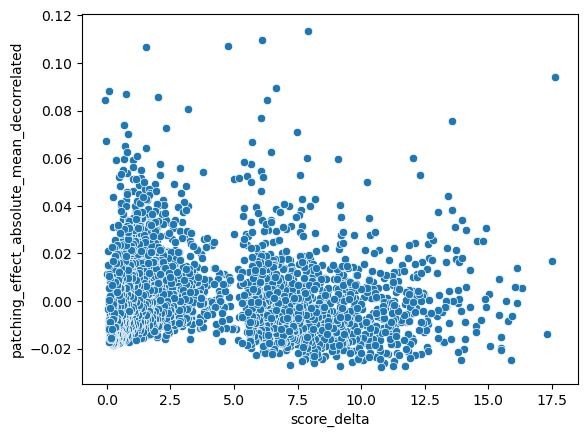

In [22]:
sns.scatterplot(data=all_data_pd, y='patching_effect_absolute_mean_decorrelated', x='score_delta')

<Axes: xlabel='score_delta', ylabel='idf_injected_term'>

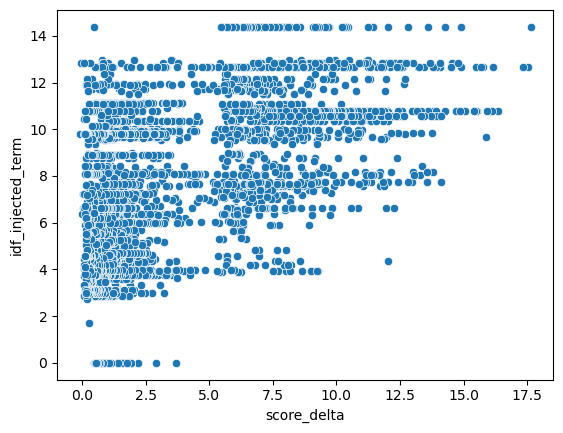

In [25]:
sns.scatterplot(data=all_data_pd, y='idf_injected_term', x='score_delta')

<Axes: xlabel='score_delta', ylabel='tfidf_injected_term'>

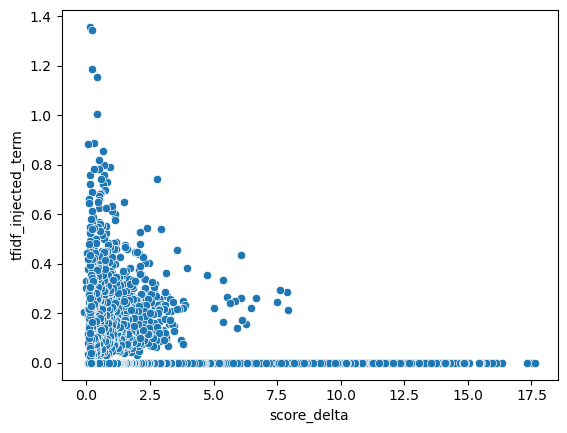

In [26]:
sns.scatterplot(data=all_data_pd, y='tfidf_injected_term', x='score_delta')

In [20]:
results_mean = train_catboost_model(all_data_pd, 'patching_effect_absolute_mean_decorrelated', properties)

TBB Warning: The number of workers is currently limited to 15. The request for 63 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0146118	test: 0.0144702	best: 0.0144702 (0)	total: 50.4ms	remaining: 50.3s
100:	learn: 0.0083143	test: 0.0093857	best: 0.0093857 (100)	total: 166ms	remaining: 1.48s
200:	learn: 0.0067270	test: 0.0090252	best: 0.0090173 (197)	total: 281ms	remaining: 1.12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.008993921019
bestIteration = 209

Shrink model to first 210 iterations.


In [21]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f16a0433ca0>,
 'rmse': 0.00899392101901807,
 'r2': 0.6388700788515791,
 'feature_importance':                                feature  importance
 3                  tfidf_injected_term   18.347070
 5                     tf_injected_term    9.551557
 0                          score_delta    9.467730
 4                    idf_injected_term    7.619704
 2              injected_term_token_len    7.447540
 17                     tfidf_std_query    5.461106
 1                            relevance    4.488040
 6                           tfidf_mean    4.379787
 11                          smog_index    3.458088
 15                     gpt2_perplexity    3.299703
 7                            tfidf_std    3.013301
 19           flesch_reading_ease_query    2.901648
 20                   gunning_fog_query    2.729683
 14        dale_chall_readability_score    2.477521
 18           english_probability_query    2.324703
 22            coleman_lia

In [23]:
results_std = train_catboost_model(all_data_pd, 'patching_effect_std_decorrelated', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0333046	test: 0.0329893	best: 0.0329893 (0)	total: 3.14ms	remaining: 3.14s
100:	learn: 0.0197785	test: 0.0223741	best: 0.0223713 (98)	total: 112ms	remaining: 996ms
200:	learn: 0.0160380	test: 0.0217414	best: 0.0217342 (199)	total: 220ms	remaining: 876ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.02171258969
bestIteration = 209

Shrink model to first 210 iterations.


In [24]:
results_std

{'model': <catboost.core.CatBoostRegressor at 0x7f15bccbf4c0>,
 'rmse': 0.021712589694954886,
 'r2': 0.5895555593270869,
 'feature_importance':                                feature  importance
 3                  tfidf_injected_term   19.002375
 0                          score_delta   12.342076
 5                     tf_injected_term   12.121189
 4                    idf_injected_term    8.878258
 2              injected_term_token_len    6.442581
 17                     tfidf_std_query    4.411230
 19           flesch_reading_ease_query    3.794175
 25               gpt2_perplexity_query    3.506278
 7                            tfidf_std    2.952657
 20                   gunning_fog_query    2.865172
 6                           tfidf_mean    2.749365
 12                  coleman_liau_index    2.733082
 22            coleman_liau_index_query    2.162791
 15                     gpt2_perplexity    1.971007
 9                  flesch_reading_ease    1.927266
 16                    tf

In [88]:
results_gini = train_catboost_model(all_data_pd, 'gini', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0753554	test: 0.0739725	best: 0.0739725 (0)	total: 1.56ms	remaining: 1.56s
100:	learn: 0.0375238	test: 0.0423620	best: 0.0423620 (100)	total: 112ms	remaining: 999ms
200:	learn: 0.0311749	test: 0.0412598	best: 0.0412426 (186)	total: 221ms	remaining: 880ms
300:	learn: 0.0270838	test: 0.0409213	best: 0.0408962 (290)	total: 331ms	remaining: 769ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04067583872
bestIteration = 367

Shrink model to first 368 iterations.


In [89]:
results_gini

{'model': <catboost.core.CatBoostRegressor at 0x7f160a2e79a0>,
 'rmse': 0.04067583874341799,
 'r2': 0.7280777605018888,
 'feature_importance':                                feature  importance
 0                          score_delta   27.559753
 4                    idf_injected_term    9.874587
 3                  tfidf_injected_term    9.163178
 5                     tf_injected_term    4.946175
 2              injected_term_token_len    4.594242
 25               gpt2_perplexity_query    3.844466
 6                           tfidf_mean    3.792431
 17                     tfidf_std_query    3.388472
 15                     gpt2_perplexity    3.068828
 22            coleman_liau_index_query    2.801659
 7                            tfidf_std    2.500590
 19           flesch_reading_ease_query    2.354381
 24  dale_chall_readability_score_query    2.168178
 14        dale_chall_readability_score    2.085281
 12                  coleman_liau_index    2.080535
 16                    tfi

In [90]:
results_gini_normalised = train_catboost_model(all_data_pd, 'gini_normalised', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0753554	test: 0.0739725	best: 0.0739725 (0)	total: 2.49ms	remaining: 2.49s
100:	learn: 0.0375238	test: 0.0423620	best: 0.0423620 (100)	total: 112ms	remaining: 994ms
200:	learn: 0.0311749	test: 0.0412598	best: 0.0412426 (186)	total: 219ms	remaining: 872ms
300:	learn: 0.0270838	test: 0.0409213	best: 0.0408962 (290)	total: 328ms	remaining: 761ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04067583876
bestIteration = 367

Shrink model to first 368 iterations.


In [91]:
results_gini_normalised

{'model': <catboost.core.CatBoostRegressor at 0x7f160a291f40>,
 'rmse': 0.04067583863544219,
 'r2': 0.7280777422332279,
 'feature_importance':                                feature  importance
 0                          score_delta   27.559752
 4                    idf_injected_term    9.874588
 3                  tfidf_injected_term    9.163178
 5                     tf_injected_term    4.946175
 2              injected_term_token_len    4.594241
 25               gpt2_perplexity_query    3.844465
 6                           tfidf_mean    3.792431
 17                     tfidf_std_query    3.388472
 15                     gpt2_perplexity    3.068829
 22            coleman_liau_index_query    2.801659
 7                            tfidf_std    2.500591
 19           flesch_reading_ease_query    2.354381
 24  dale_chall_readability_score_query    2.168178
 14        dale_chall_readability_score    2.085281
 12                  coleman_liau_index    2.080534
 16                    tfi